<a href="https://colab.research.google.com/github/Sandeepreddyr12/recom-ml-Server/blob/master/eComRecom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-commerce Recommendation System Project

This project focuses on building and evaluating a hybrid recommendation system for an e-commerce platform. The system combines collaborative filtering, content-based filtering, and popularity-based filtering to provide personalized product recommendations.



**Recommendation System Approach:**

The hybrid approach leverages the strengths of different filtering techniques:
- **Collaborative Filtering:** Recommends items based on user behavior and similarity to other users.
- **Content-Based Filtering:** Recommends items similar to those a user has liked in the past based on product features.
- **Popularity-Based Filtering:** Provides recommendations based on the overall popularity of products, useful for cold-start scenarios.

The project involves data preprocessing, feature engineering, model training, evaluation, and implementation of a real-time recommendation function.

In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

In [ ]:
!pip install faker
from faker import Faker
fake = Faker();

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.7 MB/s eta 0:00:00


#Data Generation:

Initially, synthetic data was generated to simulate an e-commerce environment. This included:
- 500 product entries with various attributes (name, category, brand, description, etc.)
- 50,000 user interaction records (views, add to cart, purchases, and reviews)
- 200 user profiles

This generated dataset serves as the foundation for training and evaluating the recommendation models.

In [ ]:
import random
import re
import unicodedata
from typing import List, Dict, Any, Optional
from datetime import datetime, timedelta

from google.colab import drive
import os
import json
import pandas as pd


def _to_slug(text: str) -> str:
    text = unicodedata.normalize("NFKD", text)
    text = text.encode("ascii", "ignore").decode("ascii")
    text = re.sub(r"[^a-zA-Z0-9\s-]", "", text)
    text = re.sub(r"\s+", "-", text.strip())
    return text.lower()


def _normalize_category(category: str) -> str:
    c = (category or "").strip().lower()
    # Normalize to our four pools
    if "t-shirt" in c or "tshirt" in c or "tee" in c:
        return "tshirt"
    if "jean" in c:
        return "jeans"
    if "shoe" in c or "sneaker" in c:
        return "shoes"
    if "watch" in c:
        return "watch"
    # default fallback
    return "tshirt"


def _default_image_pools() -> Dict[str, List[str]]:
    # Build lists based on provided naming pattern
    return {
        "tshirt": [f"tshirt{i}.jpg" for i in range(1, 13)],   # 1..12
        "jeans":  [f"jeans{i}.jpg"  for i in range(1, 10)],    # 1..9
        "shoes":  [f"shoes{i}.jpg"  for i in range(1, 11)],    # 1..10
        "watch":  [f"watch{i}.jpg"  for i in range(1, 9)],     # 1..8
    }


def _pick_two_adjacent_images(pool: List[str], base_path: str) -> List[str]:
    idx = random.randrange(len(pool))
    next_idx = (idx + 1) % len(pool)
    return [f"{base_path}/{pool[idx]}", f"{base_path}/{pool[next_idx]}"]


def _generate_rating_distribution(avg_rating: float, num_reviews: int) -> List[Dict[str, int]]:
    """Generate realistic rating distribution based on average rating and review count."""
    if num_reviews <= 0:
        return [
            {"rating": 1, "count": 0},
            {"rating": 2, "count": 0},
            {"rating": 3, "count": 0},
            {"rating": 4, "count": 0},
            {"rating": 5, "count": 0},
        ]

    # Calculate target distribution based on average rating
    target_distribution = []
    remaining_reviews = num_reviews

    # Generate realistic distribution
    for rating in range(1, 6):
        if rating == 5:
            # Assign remaining reviews to 5-star
            count = remaining_reviews
        else:
            # Calculate count based on average rating logic
            if avg_rating >= 4.5:
                # High rating products: mostly 4-5 stars
                if rating >= 4:
                    count = int(remaining_reviews * 0.7)
                elif rating == 3:
                    count = int(remaining_reviews * 0.2)
                else:
                    count = int(remaining_reviews * 0.1)
            elif avg_rating >= 4.0:
                # Good rating products: mostly 3-5 stars
                if rating >= 4:
                    count = int(remaining_reviews * 0.5)
                elif rating == 3:
                    count = int(remaining_reviews * 0.3)
                else:
                    count = int(remaining_reviews * 0.2)
            elif avg_rating >= 3.0:
                # Average rating products: spread across ratings
                if rating >= 4:
                    count = int(remaining_reviews * 0.3)
                elif rating == 3:
                    count = int(remaining_reviews * 0.4)
                else:
                    count = int(remaining_reviews * 0.3)
            else:
                # Low rating products: mostly 1-3 stars
                if rating <= 3:
                    count = int(remaining_reviews * 0.6)
                else:
                    count = int(remaining_reviews * 0.4)

            # Ensure we don't exceed remaining reviews
            count = min(count, remaining_reviews)

        target_distribution.append({"rating": rating, "count": count})
        remaining_reviews -= count

    return target_distribution


def _get_sizes_for_category(category: str) -> List[str]:
    """Get appropriate sizes based on category."""
    category_lower = category.lower()

    if "t-shirt" in category_lower or "tshirt" in category_lower:
        return ['S', 'M', 'L', 'XL', 'XXL']
    elif "jean" in category_lower:
        return ['30Wx30L', '32Wx30L', '34Wx30L', '36Wx30L', '38Wx30L']
    elif "shoe" in category_lower or "sneaker" in category_lower:
        return ['7', '8', '9', '10', '11', '12']
    elif "watch" in category_lower:
        return []  # Watches typically don't have sizes
    else:
        return ['S', 'M', 'L', 'XL']  # Default


def _get_colors_for_category(category: str) -> List[str]:
    """Get appropriate colors based on category."""
    category_lower = category.lower()

    if "t-shirt" in category_lower or "tshirt" in category_lower:
        return ['Black', 'White', 'Red', 'Blue', 'Green', 'Grey', 'Yellow']
    elif "jean" in category_lower:
        return ['Blue', 'Grey', 'Black', 'Light Blue']
    elif "shoe" in category_lower or "sneaker" in category_lower:
        return ['Black', 'White', 'Grey', 'Blue', 'Brown', 'Red']
    elif "watch" in category_lower:
        return ['Black', 'Silver', 'Gold', 'Blue', 'Brown']
    else:
        return ['Black', 'White', 'Grey']  # Default


def _generate_price_and_list_price() -> tuple[float, float]:
    """Generate realistic price and list price."""
    # Base price ranges by category (you can adjust these)
    base_price = random.uniform(15, 200)

    # 70% chance of having a list price (discount)
    if random.random() < 0.7:
        # List price is 10-40% higher than actual price
        discount_percent = random.uniform(0.1, 0.4)
        list_price = base_price / (1 - discount_percent)
        return round(base_price, 2), round(list_price, 2)
    else:
        return round(base_price, 2), 0


def _extract_tags(
    name: str,
    description: str,
    avg_rating: Optional[float],
    num_reviews: Optional[int],
) -> List[str]:
    """
    Heuristic tag extraction using keywords + quality signals.
    Produces a subset of: ['new-arrival', 'featured', 'best-seller', 'todays-deal'].
    """
    text = f"{name or ''} {description or ''}".lower()

    tags = set()

    # Keyword-driven
    if any(k in text for k in ["new", "latest", "just released", "just-arrived", "fresh"]):
        tags.add("new-arrival")
    if any(k in text for k in ["featured", "exclusive", "limited", "editor's pick", "handpicked"]):
        tags.add("featured")
    if any(k in text for k in ["bestseller", "best seller", "top seller", "fan favorite"]):
        tags.add("best-seller")
    if any(k in text for k in ["deal", "discount", "offer", "sale", "today"]):
        tags.add("todays-deal")

    # Rating/review-driven
    if avg_rating is not None and avg_rating >= 4.5:
        tags.add("best-seller")
        # High quality items might also be promoted
        if random.random() < 0.35:
            tags.add("featured")

    if num_reviews is not None and num_reviews >= 100:
        tags.add("best-seller")

    # If nothing detected, gently add 1-2 tags probabilistically
    if not tags:
        if random.random() < 0.35:
            tags.add("new-arrival")
        if random.random() < 0.25:
            tags.add("featured")
        if random.random() < 0.20 and "featured" not in tags:
            tags.add("todays-deal")

    # Cap to at most 2 tags for neatness
    if len(tags) > 2:
        tags = set(random.sample(list(tags), 2))

    return list(tags)


def generate_full_products(num_additional_products, *, seed: Optional[int] = None, base_path: str = "/media", image_pools: Optional[Dict[str, List[str]]] = None) -> List[Dict[str, Any]]:
    """
    Generates a full list of products with all required properties by combining base product info
    and generated features.
    """
    if seed is not None:
        random.seed(seed)

    pools = image_pools or _default_image_pools()
    full_products: List[Dict[str, Any]] = []

    category_brands = {
        "T-Shirts": ["Nike", "Jerzees", "Muscle Cmdr", "US Polo", "Teamspirit", "DNMX", "rare rabbit", "Bear house", "United Colors of Benetton", "Levi's", "Tommy Hilfiger", "U.S. Polo Assn.", "FILA", "GAP", "Roadster", "Jack & Jones", "Nautica", "Mast & Harbour", "American Crew", "Aeropostale", "Adidas Originals", "Bewakoof", "Allen Solly", "Duke", "Ed Hardy", "Highlander", "H&M", "Lacoste", "Nike", "Puma", "Red Tape", "Arrow", "Peter England", "Van Heusen", "Marks and Spencer", "Louis Philippe", "Raymond", "Blackberrys", "Lee", "Spykar", "The Souled Store", "Wrangler", "Pepe Jeans", "Flying Machine", "Indian Terrain", "John Players", "Fila", "Jockey", "Vero Moda", "Calvin Klein", "Zara", "XYXX Crew", "Mufti" ],
        "Jeans": ["Silver Jeans Co", "Levi's", "Essentials", "Diesel", " Gap", "Wrangler", "Flying machine","Levi's", "Wrangler", "Lee", "Pepe Jeans", "Diesel", "Spykar", "Calvin Klein", "Mufti", "Allen Solly", "Jack & Jones", "Indian Terrain", "Flying Machine", "Numero Uno", "Lee Cooper", "Denizen", "Killer Jeans", "G-Star Raw", "Tommy Hilfiger", "BOSS"],
        "Wrist Watches": ["Seiko", "Casio", "Fossil", "sonata", "G-force", "Fossil","Titan", "Fastrack", "Casio",  "Citizen", "Timex", "Rolex", "Omega", "TAG Heuer", "Longines", "Rado", "Patek Philippe", "Breitling", "Daniel Wellington"],
        "Shoes": [ "ziitop", "redtape", "crocs","Nike", "Adidas", "Puma", "Reebok", "Skechers", "Bata", "Woodland", "Hush Puppies", "Louis Philippe", "Arrow", "Mochi", "Sparx", "Relaxo", "Liberty", "Walkaroo", "Red Chief"]
    }

    category_keywords = {
        "T-Shirts": ["cotton", "slim-fit", "comfortable", "lightweight", "stretchable", "full-sleeves", "baggy","graphic"],
        "Jeans": ["denim", "boot-cut", "straight-leg", "ripped", "high-rise" ,"Torned", "black", "blue", "slim -fit"],
        "Wrist Watches": ["stainless-steel", "leather strap", "water-resistant", "chronograph", "automatic"],
        "Shoes": ["running", "sneakers", "leather", "slip-on", "breathable", "slip-ons"]
    }

    category_nouns = {
        "T-Shirts": "t-shirt",
        "Jeans": "jeans",
        "Wrist Watches": "watch",
        "Shoes": "shoe"
    }

    product_names = set() # To prevent duplicate names



    # Generate additional products
    for i in range(num_additional_products):
        while True:
            category = random.choice(list(category_brands.keys()))
            brand = random.choice(category_brands[category])
            keywords = random.sample(category_keywords[category], k=2)
            name = f"{brand} {keywords[0].capitalize()} {category_nouns[category].capitalize()}"

            if name not in product_names:
                product_names.add(name)
                break

        description = (
            f"Experience the perfect blend of style and comfort with this {keywords[0]} and {keywords[1]} "
            f"{category_nouns[category]} from {brand}. Designed to elevate your everyday look, "
            f"it's a great choice for any occasion."
        )

        avg_rating = round(random.uniform(3.2, 4.9), 2)
        num_reviews = random.randint(10, 200)
        category_key = _normalize_category(category)
        pool = pools.get(category_key, pools["tshirt"])


        images = _pick_two_adjacent_images(pool, base_path)
        tags = _extract_tags(name=name, description=description, avg_rating=avg_rating, num_reviews=num_reviews)
        price, list_price = _generate_price_and_list_price()
        count_in_stock = random.randint(5, 100)
        num_sales = random.randint(10, 200) if num_reviews else random.randint(5, 50)
        rating_distribution = _generate_rating_distribution(avg_rating, num_reviews)
        sizes = _get_sizes_for_category(category)
        colors = _get_colors_for_category(category)
        selected_colors = random.sample(colors, min(random.randint(2, 4), len(colors)))
        selected_sizes = random.sample(sizes, min(random.randint(3, 5), len(sizes)))


        full_products.append({
            "name": name,
            "slug": _to_slug(name) if name else None,
            "category": category,
            "images": images,
            "tags": tags,
            "isPublished": True,
            "price": price,
            "listPrice": list_price,
            "brand": brand,
            "avgRating": avg_rating,
            "numReviews": num_reviews,
            "ratingDistribution": rating_distribution,
            "numSales": num_sales,
            "countInStock": count_in_stock,
            "description": description,
            "sizes": selected_sizes,
            "colors": selected_colors,
            "reviews": [],
        })

    return full_products





# Generate the full products list
full_products = generate_full_products(500)


print("Full products list generated:")
display(full_products[:5])



# Save the generated products to fullProducts.json
with open('/content/fullProducts.json', 'w') as f:
    json.dump(full_products, f, indent=4)

print("Generated products saved to /content/fullProducts.json")



# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in your Google Drive to store the data
drive_folder = '/content/drive/MyDrive/generated_data'
os.makedirs(drive_folder, exist_ok=True)



genProducts_df = pd.DataFrame(full_products)

# Save to json files in the new folder
genProducts_df.to_json(os.path.join(drive_folder, "fullProducts.json"), index=False)


print(f"Data saved to {drive_folder}")

Full products list generated:


[{'name': 'Flying Machine High-rise Jeans',
  'slug': 'flying-machine-high-rise-jeans',
  'category': 'Jeans',
  'images': ['/media/jeans2.jpg', '/media/jeans3.jpg'],
  'tags': ['new-arrival', 'featured'],
  'isPublished': True,
  'price': 101.22,
  'listPrice': 119.61,
  'brand': 'Flying Machine',
  'avgRating': 3.73,
  'numReviews': 21,
  'ratingDistribution': [{'rating': 1, 'count': 6},
   {'rating': 2, 'count': 4},
   {'rating': 3, 'count': 4},
   {'rating': 4, 'count': 2},
   {'rating': 5, 'count': 5}],
  'numSales': 106,
  'countInStock': 22,
  'description': "Experience the perfect blend of style and comfort with this high-rise and black jeans from Flying Machine. Designed to elevate your everyday look, it's a great choice for any occasion.",
  'sizes': ['32Wx30L', '36Wx30L', '38Wx30L', '34Wx30L', '30Wx30L'],
  'colors': ['Blue', 'Grey', 'Light Blue', 'Black'],
  'reviews': []},
 {'name': 'Hush Puppies Slip-ons Shoe',
  'slug': 'hush-puppies-slip-ons-shoe',
  'category': 'Shoes'

Generated products saved to /content/fullProducts.json
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data saved to /content/drive/MyDrive/generated_data


#Feature Exatraction

This function `extract_ml_features_from_products` is designed to prepare the product data for use in machine learning models. It takes a list of full product dictionaries as input and extracts a subset of relevant features, creating a new list of dictionaries.

The extracted features include:
- `product_id`: A unique identifier for each product.
- `name`: The name of the product.
- `category`: The category the product belongs to.
- `brand`: The brand of the product.
- `avgRating`: The average rating of the product.
- `numReviews`: The number of reviews the product has received.
- `description`: A brief description of the product.

This function helps to isolate the specific information needed for model training, reducing the complexity of the dataset and focusing on the attributes most likely to influence recommendations.

In [ ]:
import pandas as pd
def extract_ml_features_from_products(products_list):
    """Extracts required fields for ML training from the full product list."""
    ml_products = []
    for product in products_list:
        ml_product = {
            "product_id": product.get("_id"),
            "name": product.get("name"),
            "category": product.get("category"),
            "brand": product.get("brand"),
            "avgRating": product.get("avgRating"),
            "numReviews": product.get("numReviews"),
            "description": product.get("description"),
        }
        ml_products.append(ml_product)
    return ml_products


dbProducts = pd.read_json('/content/drive/MyDrive/e-commerce-data/dbProducts.json')




# Extract ML features (optional, for clarity on what's used for ML)
ml_products_for_training = extract_ml_features_from_products(products_list=dbProducts.to_dict('records'))



print("\nML features extracted:")
display(ml_products_for_training[:5])


ML features extracted:


[{'product_id': '68a5ed903d297682284a1874',
  'name': 'Nike Mens Slim-fit Long-Sleeve T-Shirt',
  'category': 'T-Shirts',
  'brand': 'Nike',
  'avgRating': 4.71,
  'numReviews': 7,
  'description': 'Made with chemicals safer for human health and the environment'},
 {'product_id': '68a5ed903d297682284a1875',
  'name': 'Jerzees Long-Sleeve Heavyweight Blend T-Shirt',
  'category': 'T-Shirts',
  'brand': 'Jerzees',
  'avgRating': 4.2,
  'numReviews': 10,
  'description': 'Made with sustainably sourced USA grown cotton; Shoulder-to-shoulder tape; double-needle coverstitched front neck; Set-in sleeves; Rib cuffs with concealed seams; Seamless body for a wide printing area'},
 {'product_id': '68a5ed903d297682284a1876',
  'name': "Jerzees Men's Long-Sleeve T-Shirt",
  'category': 'T-Shirts',
  'brand': 'Jerzees',
  'avgRating': 4.0,
  'numReviews': 12,
  'description': 'The Jerzees long sleeve t-shirt is made with dri-power technology that wicks away moisture to keep you cool and dry througho

In [ ]:
import json

with open('/content/fullProducts.json', 'r') as f:
    full_products = json.load(f)

display(full_products[:20])

[{'name': 'Pepe Jeans Torned Jeans',
  'slug': 'pepe-jeans-torned-jeans',
  'category': 'Jeans',
  'images': ['/media/jeans9.jpg', '/media/jeans1.jpg'],
  'tags': [],
  'isPublished': True,
  'price': 158.41,
  'listPrice': 223.26,
  'brand': 'Pepe Jeans',
  'avgRating': 3.56,
  'numReviews': 66,
  'ratingDistribution': [{'rating': 1, 'count': 19},
   {'rating': 2, 'count': 14},
   {'rating': 3, 'count': 13},
   {'rating': 4, 'count': 6},
   {'rating': 5, 'count': 14}],
  'numSales': 88,
  'countInStock': 51,
  'description': "Experience the perfect blend of style and comfort with this Torned and boot-cut jeans from Pepe Jeans. Designed to elevate your everyday look, it's a great choice for any occasion.",
  'sizes': ['36Wx30L', '38Wx30L', '30Wx30L'],
  'colors': ['Grey', 'Black', 'Light Blue'],
  'reviews': []},
 {'name': 'Blackberrys Comfortable T-shirt',
  'slug': 'blackberrys-comfortable-t-shirt',
  'category': 'T-Shirts',
  'images': ['/media/tshirt9.jpg', '/media/tshirt10.jpg'],


# User and Interaction Data Generation

This section focuses on generating synthetic user profiles and interaction data to simulate realistic e-commerce user behavior.

- **User Generation:** A specified number of unique user profiles are created, each with a unique `user_id` and a `createdAt` timestamp to represent their account creation date.
- **Interaction Generation:** A larger dataset of user interactions is generated, simulating various actions users might take on an e-commerce platform, including 'view', 'add_to_cart', and 'purchase'. Each interaction record includes:
    - `userId`: The ID of the interacting user.
    - `productId`: The ID of the product involved in the interaction.
    - `interactionType`: The type of interaction (view, add\_to\_cart, or purchase).
    - `value`: A numerical value associated with the interaction (e.g., quantity for add\_to\_cart/purchase).
    - `reviewStars`: A star rating if the interaction is a purchase and a review is left.
    - `category`: The category of the product.
    - `createdAt`: The timestamp of the interaction.

The generation process incorporates realistic distributions for interaction types and review stars to better reflect real-world e-commerce data.

In [ ]:
import random
from datetime import datetime, timedelta

def generate_users(num_users):
    users = []
    for i in range(num_users):
        user = {
            "user_id": f"user_{i}",
            "createdAt": datetime.now() - timedelta(days=random.randint(0, 730))
        }
        users.append(user)
    return users

def generate_user_interactions(users, products, num_interactions):
    interactions = []
    interaction_types = ['view', 'add_to_cart', 'purchase']
    for _ in range(num_interactions):
        user = random.choice(users)
        product = random.choice(products)
        interaction_type = random.choices(
            interaction_types,
            weights=[0.7, 0.2, 0.1],  # more views, fewer purchases
            k=1
          )[0]

        value = 0
        if interaction_type == 'add_to_cart' or interaction_type == 'purchase':
            value = random.randint(1, 3)


# in real-world e-commerce platforms, reviews are usually skewed toward higher ratings, especially:

# 5 stars and 4 stars are far more common.

# 1 and 2 stars are relatively rare (unless the product is truly bad).

# This is due to positivity bias, satisfied customers being more likely to leave a review, or the seller prompting only happy customers to review.

        review_stars = 0
        if interaction_type == 'purchase' and random.random() < 0.6:  # 60% chance of review
                 review_stars = random.choices(
                      [5, 4, 3, 2, 1],
                weights=[40, 30, 13, 7, 10],  # You can tweak these
                     k=1
                      )[0]



                      # for mor comlpexity
#  You can vary weights per product type (e.g., electronics may get lower avg reviews than clothing).

# Or per user profile — experienced users may rate more harshly

        interaction = {
            "userId": user["user_id"],
            "productId": product["product_id"],  # Use the new product_id
            "interactionType": interaction_type,
            "value": value,
            "reviewStars": review_stars,
            "category": product["category"],
            "createdAt": datetime.now() - timedelta(minutes=random.randint(0, 525600))
        }
        interactions.append(interaction)
    return interactions

# Generate the data
num_users = 1000
# num_products = 500
num_interactions = 50000


products = ml_products_for_training
users = generate_users(num_users)
user_interactions = generate_user_interactions(users, products, num_interactions)

# Display a sample of the generated data
print("Sample Products:")
display(products[:5])
print("\nSample Users:")
display(users[:5])
print("\nSample User Interactions:")
display(user_interactions[:5])

Sample Products:


[{'product_id': '68a5ed903d297682284a1874',
  'name': 'Nike Mens Slim-fit Long-Sleeve T-Shirt',
  'category': 'T-Shirts',
  'brand': 'Nike',
  'avgRating': 4.71,
  'numReviews': 7,
  'description': 'Made with chemicals safer for human health and the environment'},
 {'product_id': '68a5ed903d297682284a1875',
  'name': 'Jerzees Long-Sleeve Heavyweight Blend T-Shirt',
  'category': 'T-Shirts',
  'brand': 'Jerzees',
  'avgRating': 4.2,
  'numReviews': 10,
  'description': 'Made with sustainably sourced USA grown cotton; Shoulder-to-shoulder tape; double-needle coverstitched front neck; Set-in sleeves; Rib cuffs with concealed seams; Seamless body for a wide printing area'},
 {'product_id': '68a5ed903d297682284a1876',
  'name': "Jerzees Men's Long-Sleeve T-Shirt",
  'category': 'T-Shirts',
  'brand': 'Jerzees',
  'avgRating': 4.0,
  'numReviews': 12,
  'description': 'The Jerzees long sleeve t-shirt is made with dri-power technology that wicks away moisture to keep you cool and dry througho


Sample Users:


[{'user_id': 'user_0',
  'createdAt': datetime.datetime(2025, 4, 17, 16, 1, 16, 967540)},
 {'user_id': 'user_1',
  'createdAt': datetime.datetime(2024, 3, 30, 16, 1, 16, 967571)},
 {'user_id': 'user_2',
  'createdAt': datetime.datetime(2024, 6, 18, 16, 1, 16, 967578)},
 {'user_id': 'user_3',
  'createdAt': datetime.datetime(2025, 4, 28, 16, 1, 16, 967581)},
 {'user_id': 'user_4',
  'createdAt': datetime.datetime(2025, 6, 14, 16, 1, 16, 967584)}]


Sample User Interactions:


[{'userId': 'user_166',
  'productId': '68a5ed913d297682284a1892',
  'interactionType': 'view',
  'value': 0,
  'reviewStars': 0,
  'category': 'Wrist Watches',
  'createdAt': datetime.datetime(2025, 8, 11, 1, 49, 16, 970024)},
 {'userId': 'user_674',
  'productId': '68a5ed933d297682284a1a6e',
  'interactionType': 'purchase',
  'value': 3,
  'reviewStars': 1,
  'category': 'Jeans',
  'createdAt': datetime.datetime(2025, 7, 23, 2, 43, 16, 970049)},
 {'userId': 'user_5',
  'productId': '68a5ed923d297682284a196d',
  'interactionType': 'view',
  'value': 0,
  'reviewStars': 0,
  'category': 'Shoes',
  'createdAt': datetime.datetime(2025, 1, 4, 6, 13, 16, 970060)},
 {'userId': 'user_316',
  'productId': '68a5ed923d297682284a194f',
  'interactionType': 'add_to_cart',
  'value': 2,
  'reviewStars': 0,
  'category': 'Shoes',
  'createdAt': datetime.datetime(2025, 5, 11, 3, 3, 16, 970070)},
 {'userId': 'user_634',
  'productId': '68a5ed933d297682284a1a03',
  'interactionType': 'add_to_cart',
  

In [ ]:

import pandas as pd


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in your Google Drive to store the data
drive_folder = '/content/drive/MyDrive/e-commerce-data'
os.makedirs(drive_folder, exist_ok=True)


# Convert to pandas DataFrames
products_df = pd.DataFrame(products)
users_df = pd.DataFrame(users)
interactions_df = pd.DataFrame(user_interactions)

# Save to CSV files in the new folder
products_df.to_csv(os.path.join(drive_folder, "products.csv"), index=False)
users_df.to_csv(os.path.join(drive_folder, "users.csv"), index=False)
interactions_df.to_csv(os.path.join(drive_folder, "interactions.csv"), index=False)

print(f"Data saved to {drive_folder}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data saved to /content/drive/MyDrive/e-commerce-data


In [ ]:
# Load the data
products_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/products.csv')
users_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/users.csv')
interactions_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/interactions.csv')

# Display basic info
display("Products shape:", products_df.head())
# print("Users shape:", users_df.head())
# print("Users shape:", users_df.shape)
# print("Interactions shape:", interactions_df.shape)

'Products shape:'

,product_id,name,category,brand,avgRating,numReviews,description
0,68a5ed903d297682284a1874,Nike Mens Slim-fit Long-Sleeve T-Shirt,T-Shirts,Nike,4.71,7,Made with chemicals safer for human health and...
1,68a5ed903d297682284a1875,Jerzees Long-Sleeve Heavyweight Blend T-Shirt,T-Shirts,Jerzees,4.20,10,Made with sustainably sourced USA grown cotton...
2,68a5ed903d297682284a1876,Jerzees Men's Long-Sleeve T-Shirt,T-Shirts,Jerzees,4.00,12,The Jerzees long sleeve t-shirt is made with d...
3,68a5ed903d297682284a1877,Decrum Mens Plain Long Sleeve T-Shirt - Comfor...,T-Shirts,Jerzees,3.85,14,Elevate your outfit with this soft long sleeve...
4,68a5ed903d297682284a1878,Muscle Cmdr Men's Slim Fit Henley Shirt Long&S...,T-Shirts,Muscle Cmdr,3.66,15,Slim Fit Design:Men's Muscle Slim Fit Button H...


# Task
Using the data from "/content/interactions.csv", "/content/products.csv", and "/content/users.csv", build and evaluate a hybrid recommendation system that combines collaborative filtering, content-based filtering, and popularity-based filtering. The system should be able to handle cold-start users. Save the trained models and provide a function for real-time recommendations. Finally, visualize the distribution of interaction types and implicit ratings.

## Setup and data loading

### Subtask:
 Install necessary libraries and load the `products`, `users`, and `interactions` datasets from the specified file paths.


In [ ]:
!pip install scikit-surprise pandas scikit-learn scipy matplotlib seaborn

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, LabelEncoder
from surprise import Dataset, Reader, SVD, NMF, KNNBasic
from surprise.model_selection import train_test_split, cross_validate
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load the data
products_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/products.csv')
users_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/users.csv')
interactions_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/interactions.csv')

# Display basic info
print("Products shape:", products_df.shape)
print("Users shape:", users_df.shape)
print("Interactions shape:", interactions_df.shape)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

ImportError: numpy.core.multiarray failed to import (auto-generated because you didn't call 'numpy.import_array()' after cimporting numpy; use '<void>numpy._import_array' to disable if you are certain you don't need it).

In [ ]:
# Filter interactions for user_0 and user_1
user_0_interactions = interactions_df[interactions_df['userId'] == 'user_0']
user_1_interactions = interactions_df[interactions_df['userId'] == 'user_1']

# Find common products
common_products = pd.merge(user_0_interactions, user_1_interactions, on='productId', suffixes=('_user0', '_user1'))

# Add a column to indicate matched products
common_products['matched_interaction'] = True

print("User 0 Interactions:")
display(user_0_interactions)

print("\nUser 1 Interactions:")
display(user_1_interactions)

print("\nCommon Products between User 0 and User 1:")
display(common_products)

User 0 Interactions:


,userId,productId,interactionType,value,reviewStars,category,createdAt
464,user_0,68a5ed933d297682284a1a7a,view,0,0,Shoes,2025-01-29 09:41:16.973065
784,user_0,68a5ed913d297682284a18e9,view,0,0,Wrist Watches,2024-12-22 09:37:16.975096
1277,user_0,68a5ed923d297682284a19cb,view,0,0,T-Shirts,2025-04-06 15:53:16.979367
1358,user_0,68a5ed913d297682284a18a1,view,0,0,Jeans,2025-01-17 05:22:16.980085
1748,user_0,68a5ed913d297682284a193d,view,0,0,Wrist Watches,2024-09-08 13:44:16.982320
1774,user_0,68a5ed923d297682284a199e,purchase,2,0,T-Shirts,2024-12-08 10:14:16.982652
2797,user_0,68a5ed933d297682284a1a3f,view,0,0,T-Shirts,2024-12-04 09:27:16.989814
3108,user_0,68a5ed933d297682284a1a53,add_to_cart,3,0,T-Shirts,2024-09-10 11:07:16.991714
4702,user_0,68a5ed923d297682284a19c6,view,0,0,T-Shirts,2024-12-20 20:16:17.000988
6179,user_0,68a5ed923d297682284a19d3,view,0,0,Wrist Watches,2024-09-28 15:21:17.008933



User 1 Interactions:


,userId,productId,interactionType,value,reviewStars,category,createdAt
743,user_1,68a5ed913d297682284a1932,view,0,0,Jeans,2024-10-28 19:07:16.974802
923,user_1,68a5ed913d297682284a18c4,view,0,0,Jeans,2024-10-11 18:13:16.975963
1023,user_1,68a5ed913d297682284a18ba,add_to_cart,2,0,Wrist Watches,2024-12-15 20:59:16.976557
2429,user_1,68a5ed923d297682284a199c,purchase,3,5,Wrist Watches,2025-01-11 09:42:16.986407
2868,user_1,68a5ed913d297682284a18e7,view,0,0,T-Shirts,2025-01-17 17:34:16.990388
3560,user_1,68a5ed933d297682284a19dc,add_to_cart,2,0,Shoes,2024-12-06 09:47:16.994702
5509,user_1,68a5ed913d297682284a18f0,view,0,0,Wrist Watches,2024-11-24 16:16:17.005342
6722,user_1,68a5ed933d297682284a1a58,add_to_cart,3,0,T-Shirts,2024-12-29 03:43:17.011877
7415,user_1,68a5ed913d297682284a193d,add_to_cart,3,0,Wrist Watches,2025-03-19 08:17:17.015865
7963,user_1,68a5ed933d297682284a1a08,view,0,0,T-Shirts,2024-08-21 11:59:17.018763



Common Products between User 0 and User 1:


,userId_user0,productId,interactionType_user0,value_user0,reviewStars_user0,category_user0,createdAt_user0,userId_user1,interactionType_user1,value_user1,reviewStars_user1,category_user1,createdAt_user1,matched_interaction
0,user_0,68a5ed913d297682284a193d,view,0,0,Wrist Watches,2024-09-08 13:44:16.982320,user_1,add_to_cart,3,0,Wrist Watches,2025-03-19 08:17:17.015865,True
1,user_0,68a5ed913d297682284a193d,view,0,0,Wrist Watches,2024-09-08 13:44:16.982320,user_1,add_to_cart,2,0,Wrist Watches,2025-07-28 07:31:17.020862,True
2,user_0,68a5ed913d297682284a18c5,purchase,1,0,Shoes,2025-04-06 03:40:17.047748,user_1,view,0,0,Shoes,2025-03-06 04:51:17.217013,True
3,user_0,68a5ed923d297682284a195b,purchase,1,5,Shoes,2025-03-17 16:14:17.077981,user_1,view,0,0,Shoes,2025-03-07 23:22:17.300197,True
4,user_0,68a5ed923d297682284a1975,view,0,0,Wrist Watches,2025-05-16 00:08:17.099686,user_1,view,0,0,Wrist Watches,2025-07-12 02:09:17.319920,True
5,user_0,68a5ed923d297682284a19ca,view,0,0,T-Shirts,2024-10-23 15:17:17.110098,user_1,view,0,0,T-Shirts,2024-08-30 02:16:17.295942,True


## Detailed data analysis

### Subtask:
Analyze user interaction patterns more deeply, analyze product features, identify data sparsity levels, and analyze the distribution of implicit ratings.


In [ ]:
# 1. Calculate and print the total number of interactions per user
user_interaction_counts = interactions_df.groupby('userId').size().sort_values(ascending=False)
print("Total number of interactions per user:")
display(user_interaction_counts.head())
display(user_interaction_counts.describe())

# 2. Analyze the unique values and frequency of different interaction types
print("\nFrequency of different interaction types:")
display(interactions_df['interactionType'].value_counts())

# 3. Examine the distribution of product categories and brands
print("\nDistribution of product categories:")
display(products_df['category'].value_counts())
print("\nDistribution of product brands (Top 10):")
display(products_df['brand'].value_counts().head(10))

# 4. Compute and display the average number of interactions per product
product_interaction_counts = interactions_df.groupby('productId').size()
print("\nAverage number of interactions per product:")
display(product_interaction_counts.mean())
print("\nDistribution of interactions per product:")
display(product_interaction_counts.describe())

# 5. Analyze the distribution of reviewStars
print("\nDistribution of reviewStars:")
display(interactions_df['reviewStars'].value_counts())

Total number of interactions per user:


,0
userId,
user_805,77
user_542,73
user_55,73
user_858,72
user_572,70


,0
count,1000.000000
mean,50.000000
std,7.067245
min,31.000000
25%,45.000000
50%,50.000000
75%,55.000000
max,77.000000



Frequency of different interaction types:


,count
interactionType,
view,35075
add_to_cart,10049
purchase,4876



Distribution of product categories:


,count
category,
T-Shirts,182
Jeans,147
Shoes,107
Wrist Watches,88



Distribution of product brands (Top 10):


,count
brand,
Nike,12
Levi's,11
Indian Terrain,11
Wrangler,11
Pepe Jeans,11
Tommy Hilfiger,10
Allen Solly,10
Calvin Klein,10
Mufti,10



Average number of interactions per product:


95.41984732824427


Distribution of interactions per product:


,0
count,524.000000
mean,95.419847
std,9.813133
min,68.000000
25%,89.000000
50%,95.000000
75%,102.000000
max,132.000000



Distribution of reviewStars:


,count
reviewStars,
0,47126
5,1101
4,867
3,399
1,282
2,225


## Data preprocessing and feature engineering

### Subtask:
Convert `createdAt` columns to datetime objects and create `implicit_rating` and `content_features` columns.


**Reasoning**:
Convert 'createdAt' columns to datetime objects, calculate interaction weights and implicit ratings, and create the 'content_features' column in preparation for the next steps of the recommendation system.



In [ ]:
# Convert datetime strings to datetime objects
users_df['createdAt'] = pd.to_datetime(users_df['createdAt'])
interactions_df['createdAt'] = pd.to_datetime(interactions_df['createdAt'])

# Create interaction weights based on interaction type
interaction_weights = {
    'view': 1,
    'add_to_cart': 2,
    'purchase': 3,
}

# Add weight column
interactions_df['weight'] = interactions_df.apply(
    lambda x: 3 if x['reviewStars'] > 0 else interaction_weights.get(x['interactionType'], 1),
    axis=1
)



def calculate_implicit_rating(x):
    review = x['reviewStars'] if x['reviewStars'] not in [0, np.nan] else 3.5
    review_adjustment = review - 3.0  # reviews below 3 subtract, above add

    if(review == 1):
       review_adjustment -= 2.0  # Extra penalty for 1-star reviews and also we need to filter while recomeding

    return x['weight'] + review_adjustment

interactions_df['implicit_rating'] = interactions_df.apply(calculate_implicit_rating, axis=1)





# Normalize implicit ratings to 1-5 scale
interactions_df['implicit_rating'] = 1 + (interactions_df['implicit_rating'] - interactions_df['implicit_rating'].min()) * 4 / (
    interactions_df['implicit_rating'].max() - interactions_df['implicit_rating'].min()
)

display(interactions_df.tail(10))

print("Interaction statistics:")
display(interactions_df.groupby('interactionType').size())
print("\nImplicit rating distribution:")
display(interactions_df['implicit_rating'].describe())

# Create product features for content-based filtering
# Combine text features
products_df['content_features'] = (
    products_df['name'].fillna('') + ' ' +
    products_df['category'].fillna('') + ' ' +
    products_df['brand'].fillna('') + ' ' +
    products_df['description'].fillna('')
)

print("\nProducts Sample with content_features:")
display(products_df.head())
display(products_df["content_features"])

,userId,productId,interactionType,value,reviewStars,category,createdAt,weight,implicit_rating
49990,user_377,68a5ed933d297682284a1a2f,purchase,3,2,Jeans,2025-04-09 07:35:17.328153,3,3.000000
49991,user_623,68a5ed923d297682284a1996,purchase,1,1,Jeans,2025-04-14 13:19:17.328160,3,1.000000
49992,user_524,68a5ed913d297682284a18d8,view,0,0,Wrist Watches,2024-11-26 04:51:17.328165,1,2.666667
49993,user_295,68a5ed933d297682284a1a34,view,0,0,Jeans,2025-05-14 18:19:17.328170,1,2.666667
49994,user_699,68a5ed923d297682284a1958,purchase,1,3,T-Shirts,2025-04-23 05:04:17.328176,3,3.666667
49995,user_290,68a5ed913d297682284a18bd,purchase,3,1,T-Shirts,2025-02-13 21:18:17.328183,3,1.000000
49996,user_817,68a5ed913d297682284a18d6,view,0,0,Wrist Watches,2025-01-30 01:45:17.328187,1,2.666667
49997,user_8,68a5ed913d297682284a18e3,view,0,0,T-Shirts,2025-01-21 06:41:17.328192,1,2.666667
49998,user_288,68a5ed913d297682284a18aa,view,0,0,Wrist Watches,2024-11-30 10:52:17.328197,1,2.666667
49999,user_515,68a5ed933d297682284a19e9,view,0,0,Shoes,2024-10-02 21:59:17.328201,1,2.666667


Interaction statistics:


,0
interactionType,
add_to_cart,10049
purchase,4876
view,35075



Implicit rating distribution:


,implicit_rating
count,50000.000000
mean,2.934400
std,0.530124
min,1.000000
25%,2.666667
50%,2.666667
75%,3.333333
max,5.000000



Products Sample with content_features:


,product_id,name,category,brand,avgRating,numReviews,description,content_features
0,68a5ed903d297682284a1874,Nike Mens Slim-fit Long-Sleeve T-Shirt,T-Shirts,Nike,4.71,7,Made with chemicals safer for human health and...,Nike Mens Slim-fit Long-Sleeve T-Shirt T-Shirt...
1,68a5ed903d297682284a1875,Jerzees Long-Sleeve Heavyweight Blend T-Shirt,T-Shirts,Jerzees,4.20,10,Made with sustainably sourced USA grown cotton...,Jerzees Long-Sleeve Heavyweight Blend T-Shirt ...
2,68a5ed903d297682284a1876,Jerzees Men's Long-Sleeve T-Shirt,T-Shirts,Jerzees,4.00,12,The Jerzees long sleeve t-shirt is made with d...,Jerzees Men's Long-Sleeve T-Shirt T-Shirts Jer...
3,68a5ed903d297682284a1877,Decrum Mens Plain Long Sleeve T-Shirt - Comfor...,T-Shirts,Jerzees,3.85,14,Elevate your outfit with this soft long sleeve...,Decrum Mens Plain Long Sleeve T-Shirt - Comfor...
4,68a5ed903d297682284a1878,Muscle Cmdr Men's Slim Fit Henley Shirt Long&S...,T-Shirts,Muscle Cmdr,3.66,15,Slim Fit Design:Men's Muscle Slim Fit Button H...,Muscle Cmdr Men's Slim Fit Henley Shirt Long&S...


,content_features
0,Nike Mens Slim-fit Long-Sleeve T-Shirt T-Shirt...
1,Jerzees Long-Sleeve Heavyweight Blend T-Shirt ...
2,Jerzees Men's Long-Sleeve T-Shirt T-Shirts Jer...
3,Decrum Mens Plain Long Sleeve T-Shirt - Comfor...
4,Muscle Cmdr Men's Slim Fit Henley Shirt Long&S...
...,...
519,Jockey Slim-fit T-shirt T-Shirts Jockey Experi...
520,Van Heusen Full-sleeves T-shirt T-Shirts Van H...
521,Jack & Jones Boot-cut Jeans Jeans Jack & Jones...
522,Spykar Black Jeans Jeans Spykar Experience the...


## Enhance data representation

### Subtask:
Engineer additional features for users and products, and incorporate temporal features.


**Reasoning**:
engineer additional features for users and products, and incorporate temporal features into the interactions DataFrame by calculating aggregated interaction statistics for users and products, creating account age features for users, and adding temporal features to interactions, then merge these features and display the updated interactions DataFrame.



In [ ]:
# Reload dataframes to ensure all original columns are present
products_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/products.csv')
users_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/users.csv')
interactions_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/interactions.csv')

# Convert datetime strings to datetime objects
users_df['createdAt'] = pd.to_datetime(users_df['createdAt'])
interactions_df['createdAt'] = pd.to_datetime(interactions_df['createdAt'])

# Re-calculate interaction weights and implicit ratings (as this cell might be run independently)
interaction_weights = {
    'view': 1,
    'add_to_cart': 2,
    'purchase': 3,
}

interactions_df['weight'] = interactions_df.apply(
    lambda x: 3 if x['reviewStars'] > 0 else interaction_weights.get(x['interactionType'], 1),
    axis=1
)

def calculate_implicit_rating(x):
    review = x['reviewStars'] if x['reviewStars'] not in [0, np.nan] else 3.5
    review_adjustment = review - 3.0  # reviews below 3 subtract, above add

    if(review == 1):
       review_adjustment -= 2.0  # Extra penalty for 1-star reviews and also we need to filter while recomeding

    return x['weight'] + review_adjustment

interactions_df['implicit_rating'] = interactions_df.apply(calculate_implicit_rating, axis=1)

# Normalize implicit ratings to 1-5 scale
interactions_df['implicit_rating'] = 1 + (interactions_df['implicit_rating'] - interactions_df['implicit_rating'].min()) * 4 / (
    interactions_df['implicit_rating'].max() - interactions_df['implicit_rating'].min()
)

# Calculate product popularity scores (regenerated here)
# Add a time decay factor to interactions - giving more weight to recent interactions
# Using a simple exponential decay: weight = exp(-decay_rate * time_since_interaction_days)
# We need the 'time_since_interaction_days' column which is created later in this cell.
# For now, calculate the base interaction count, avg rating, and purchase count
product_popularity = interactions_df.groupby('productId').agg({
    'userId': 'count',  # Number of interactions
    'implicit_rating': 'mean',  # Average rating
    'interactionType': lambda x: (x == 'purchase').sum()  # Number of purchases
}).rename(columns={
    'userId': 'interaction_count',
    'implicit_rating': 'avg_rating',
    'interactionType': 'purchase_count'
})

# Calculate popularity score based on these initial counts
max_interaction = product_popularity['interaction_count'].max()
max_purchase = product_popularity['purchase_count'].max()

product_popularity['popularity_score'] = (
    0.3 * (product_popularity['interaction_count'] / max_interaction if max_interaction > 0 else 0) +
    0.3 * (product_popularity['avg_rating'] / 5.0) +
    0.2 * (product_popularity['purchase_count'] / max_purchase if max_purchase > 0 else 0)
)

# Merge with product info to get 'name', 'avgRating', 'numReviews'
product_popularity = product_popularity.merge(
    products_df[['product_id', 'name', 'avgRating', 'numReviews']],
    left_index=True, # Merge on index of product_popularity (which is productId)
    right_on='product_id',
    how='left'
)

# Re-calculate popularity score including numReviews
max_reviews = product_popularity['numReviews'].max()
product_popularity['popularity_score'] = (
    0.3 * (product_popularity['interaction_count'] / max_interaction if max_interaction > 0 else 0) +
    0.3 * (product_popularity['avg_rating'] / 5.0) +
    0.2 * (product_popularity['purchase_count'] / max_purchase if max_purchase > 0 else 0) +
    0.2 * (product_popularity['numReviews'] / max_reviews if max_reviews > 0 else 0)
)


# 1. Create new features for users_df

# Calculate total number of interactions per user
user_total_interactions = interactions_df.groupby('userId').size().reset_index(name='total_interactions')
users_df = users_df.merge(user_total_interactions, left_on='user_id', right_on='userId', how='left').fillna(0)

# Calculate average implicit rating per user
user_avg_rating = interactions_df.groupby('userId')['implicit_rating'].mean().reset_index(name='avg_user_rating')
users_df = users_df.merge(user_avg_rating, left_on='user_id', right_on='userId', how='left').fillna(interactions_df['implicit_rating'].mean()) # Fill NaN with overall mean


# Calculate account age in days
users_df['account_age_days'] = (datetime.now() - users_df['createdAt']).dt.days

# 2. Create more sophisticated features for products_df

# Word embeddings (using TF-IDF as a proxy for now, as full embeddings require more setup)
# The TF-IDF matrix and product_similarity_df were already created in a previous step.
# We can use the product_similarity_df as a feature, but it's a matrix, not a column.
# For simplicity in merging, we can use the popularity score as a product feature.
# Product popularity was already calculated and merged into product_popularity df in a previous step.
# We can merge product_popularity into products_df to have a single product feature source.
products_df = products_df.merge(
    product_popularity[['product_id', 'popularity_score']],
    on='product_id',
    how='left'
).fillna(product_popularity['popularity_score'].mean()) # Fill NaN with overall mean

# One-hot encode categorical features 'category' and 'brand'
products_df = pd.get_dummies(products_df, columns=['category', 'brand'], prefix=['category', 'brand'])


# 3. Add temporal features to interactions_df

# Time since interaction occurred in days
interactions_df['time_since_interaction_days'] = (datetime.now() - interactions_df['createdAt']).dt.days

# Day of the week (0=Monday, 6=Sunday)
interactions_df['day_of_week'] = interactions_df['createdAt'].dt.dayofweek

# Hour of the day
interactions_df['hour_of_day'] = interactions_df['createdAt'].dt.hour

# 4. Merge the newly created user and product features back into the interactions_df DataFrame

# Check and convert 'productId' and 'product_id' columns to string type before merging
interactions_df['productId'] = interactions_df['productId'].astype(str)
products_df['product_id'] = products_df['product_id'].astype(str)

# Merge user features
interactions_df = interactions_df.merge(
    users_df[['user_id', 'total_interactions', 'avg_user_rating', 'account_age_days']],
    left_on='userId',
    right_on='user_id',
    how='left'
).drop('user_id', axis=1) # Drop the duplicate user_id column from users_df after merging


# Merge product features (using product_id as the key)
# We need to merge the one-hot encoded product features and popularity score
interactions_df = interactions_df.merge(
    products_df.drop(['name', 'description', 'avgRating', 'numReviews'], axis=1, errors='ignore'), # Dropped content_features
    left_on='productId',
    right_on='product_id',
    how='left'
).drop('product_id', axis=1)


# 5. Display the first few rows of the updated interactions_df DataFrame
print("\nUpdated Interactions DataFrame with new features:")
display(interactions_df.head())

print("\nImplicit rating distribution:")
display(interactions_df['implicit_rating'].describe())


Updated Interactions DataFrame with new features:


,userId,productId,interactionType,value,reviewStars,category,createdAt,weight,implicit_rating,time_since_interaction_days,...,brand_Woodland,brand_Wrangler,brand_XYXX Crew,brand_Zara,brand_adidas,brand_crocs,brand_rare rabbit,brand_redtape,brand_sonata,brand_ziitop
0,user_166,68a5ed913d297682284a1892,view,0,0,Wrist Watches,2025-08-11 01:49:16.970024,1,2.666667,9,...,False,False,False,False,False,False,False,False,False,False
1,user_674,68a5ed933d297682284a1a6e,purchase,3,1,Jeans,2025-07-23 02:43:16.970049,3,1.000000,28,...,False,False,False,False,False,False,False,False,False,False
2,user_5,68a5ed923d297682284a196d,view,0,0,Shoes,2025-01-04 06:13:16.970060,1,2.666667,228,...,False,False,False,False,False,False,False,False,False,False
3,user_316,68a5ed923d297682284a194f,add_to_cart,2,0,Shoes,2025-05-11 03:03:16.970070,2,3.333333,101,...,False,False,False,False,False,False,False,False,False,False
4,user_634,68a5ed933d297682284a1a03,add_to_cart,2,0,Wrist Watches,2025-06-02 08:06:16.970078,2,3.333333,79,...,False,False,False,False,False,False,False,False,False,False



Implicit rating distribution:


,implicit_rating
count,50000.000000
mean,2.934400
std,0.530124
min,1.000000
25%,2.666667
50%,2.666667
75%,3.333333
max,5.000000


## Evaluation and visualization

### Subtask:
Visualize the distribution of interaction types and implicit ratings.


**Reasoning**:
Visualize the distribution of interaction types and implicit ratings as requested in the subtask instructions.



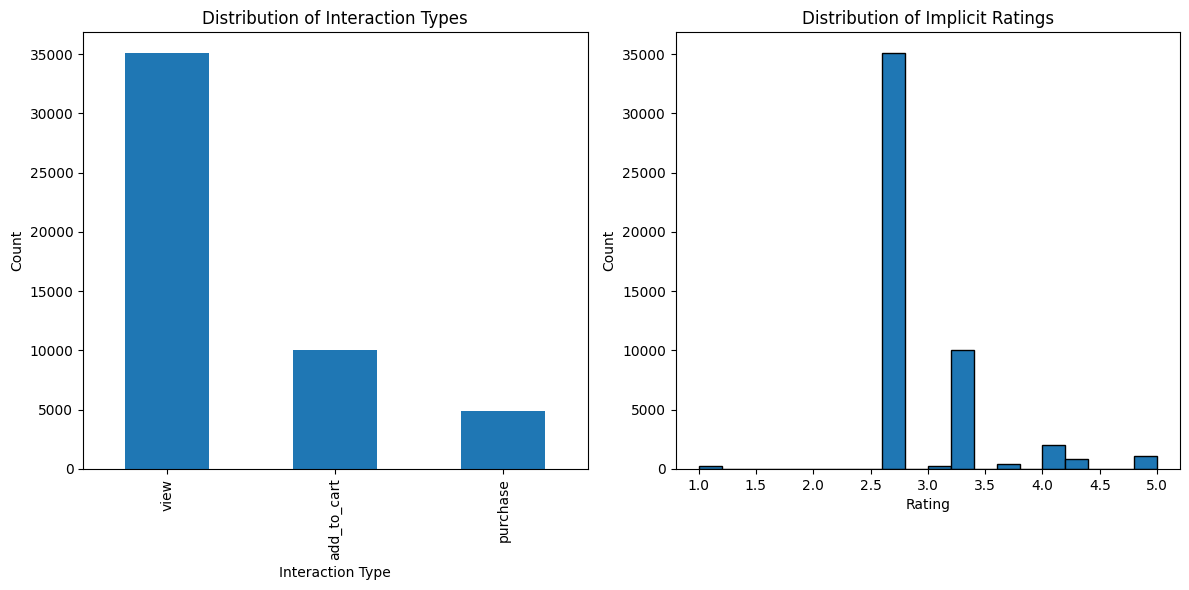

In [ ]:
# Visualize interaction distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
interactions_df['interactionType'].value_counts().plot(kind='bar')
plt.title('Distribution of Interaction Types')
plt.xlabel('Interaction Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(interactions_df['implicit_rating'], bins=20, edgecolor='black')
plt.title('Distribution of Implicit Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Collaborative filtering

### Subtask:
Prepare the data for the `surprise` library and train SVD, NMF, and KNN models.


**Reasoning**:
I will now prepare the data for the `surprise` library by creating a `Reader` object, a user-item matrix, and a `surprise` dataset. I will then split the data and train the SVD, NMF, and KNN models as per the instructions.



In [ ]:
# Prepare data for Surprise library
reader = Reader(rating_scale=(1, 5))

# Create user-item matrix
user_item_matrix = interactions_df.groupby(['userId', 'productId'])['implicit_rating'].mean().reset_index()

# Create Surprise dataset
data = Dataset.load_from_df(user_item_matrix[['userId', 'productId', 'implicit_rating']], reader)

# Split data
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train multiple collaborative filtering models
print("Training collaborative filtering models...")

# SVD Model
svd_model = SVD(n_factors=50, n_epochs=20, random_state=42)
svd_model.fit(trainset)

# NMF Model
nmf_model = NMF(n_factors=50, n_epochs=20, random_state=42)
nmf_model.fit(trainset)

# KNN Model
knn_model = KNNBasic(k=30, sim_options={'name': 'cosine', 'user_based': True})
knn_model.fit(trainset)

print("Collaborative filtering models trained!")

Training collaborative filtering models...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Collaborative filtering models trained!


## Evaluate collaborative filtering models

### Subtask:
Evaluate the SVD, NMF, and KNN models using 5-fold cross-validation.


**Reasoning**:
I will now evaluate the SVD, NMF, and KNN models using 5-fold cross-validation as requested in the subtask instructions. I will use the `cross_validate` function for each model and print the results.



In [ ]:
# Evaluate the SVD, NMF, and KNN models using cross-validation
print("Evaluating SVD model...")
svd_eval = cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

print("\nEvaluating NMF model...")
nmf_eval = cross_validate(nmf_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

print("\nEvaluating KNN model...")
knn_eval = cross_validate(knn_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print the results
print("\nSVD Cross-Validation Results:")
print(f"Average RMSE: {svd_eval['test_rmse'].mean()}")
print(f"Average MAE: {svd_eval['test_mae'].mean()}")

print("\nNMF Cross-Validation Results:")
print(f"Average RMSE: {nmf_eval['test_rmse'].mean()}")
print(f"Average MAE: {nmf_eval['test_mae'].mean()}")

print("\nKNN Cross-Validation Results:")
print(f"Average RMSE: {knn_eval['test_rmse'].mean()}")
print(f"Average MAE: {knn_eval['test_mae'].mean()}")

Evaluating SVD model...
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5327  0.5448  0.5340  0.5347  0.5448  0.5382  0.0054  
MAE (testset)     0.3924  0.3986  0.3906  0.3925  0.3965  0.3941  0.0029  
Fit time          0.36    0.38    0.36    0.37    0.36    0.37    0.01    
Test time         0.05    0.06    0.06    0.06    0.04    0.05    0.01    

Evaluating NMF model...
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6800  1.6766  1.6806  1.6892  1.6841  1.6821  0.0043  
MAE (testset)     1.6066  1.5988  1.6044  1.6136  1.6069  1.6061  0.0048  
Fit time          0.50    0.49    0.74    0.78    0.80    0.66    0.14    
Test time         0.15    0.05    0.08    0.08    0.09    0.09    0.03    

Evaluating KNN model...
Computing the cosine similarity matrix...
Done computing similarity 

## Hyperparameter tuning

### Subtask:
Use `GridSearchCV` to find the best hyperparameters for the SVD model.


**Reasoning**:
I will now perform hyperparameter tuning on the SVD model using `GridSearchCV` to find the best parameters, as requested in the subtask instructions. This involves importing `GridSearchCV`, defining a parameter grid, instantiating and fitting the `GridSearchCV` object, and then printing the best RMSE score and corresponding parameters.



In [ ]:
from surprise.model_selection import GridSearchCV

# Define a parameter grid for the SVD model
param_grid_svd = {
    'n_epochs': [20, 30],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1]
}

# Define a parameter grid for the NMF model
param_grid_nmf = {
    'n_factors': [15, 20],
    'n_epochs': [20, 30],
}

# Instantiate a GridSearchCV object
gs_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse', 'mae'], cv=3, refit=True)
gs_nmf = GridSearchCV(NMF, param_grid_nmf, measures=['rmse', 'mae'], cv=3, refit=True)
gs_knn = GridSearchCV(KNNBasic, param_grid_nmf, measures=['rmse', 'mae'], cv=3, refit=True)

# Fit the GridSearchCV object to the data
gs_svd.fit(data)
gs_nmf.fit(data)
gs_knn.fit(data)

# Print the best score for RMSE and the corresponding parameters
print("SVD Best RMSE score:", gs_svd.best_score['rmse'])
print("SVD Best MAE score:", gs_svd.best_score['mae'])
print("SVD Best parameters:", gs_svd.best_params['rmse'])
print("\n")
print("NMF Best RMSE score:", gs_nmf.best_score['rmse'])
print("NMF Best MAE score:", gs_nmf.best_score['mae'])
print("NMF Best parameters:", gs_nmf.best_params['rmse'])
print("\n")
print("KNN Best RMSE score:", gs_knn.best_score['rmse'])
print("KNN Best MAE score:", gs_knn.best_score['mae'])
print("KNN Best parameters:", gs_knn.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
SVD Best RMSE score: 0.5356965841146036
SVD Best MA

## visualizing

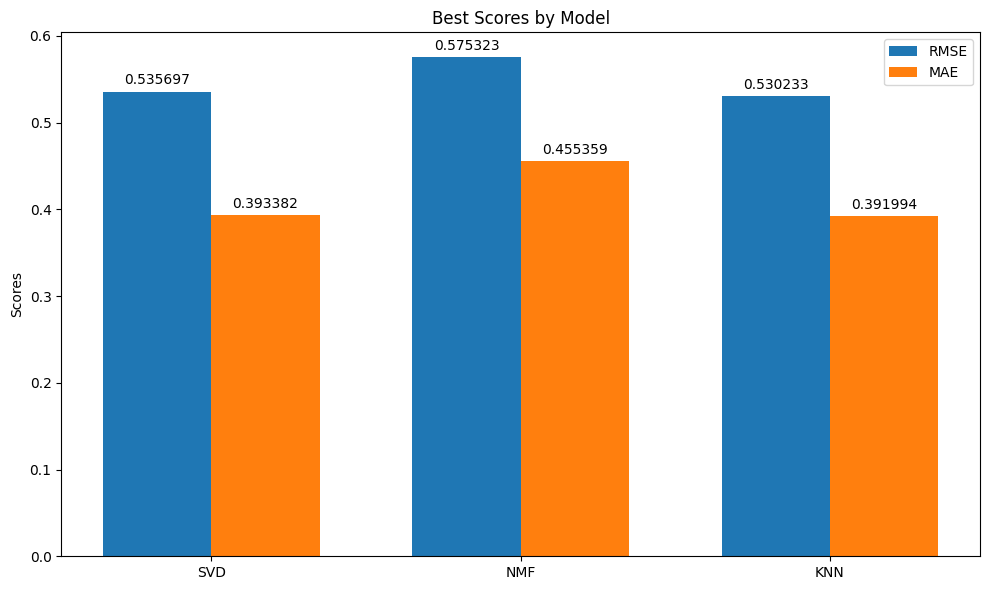

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the GridSearchCV results
models = ['SVD', 'NMF', 'KNN']
best_rmse_scores = [gs_svd.best_score['rmse'], gs_nmf.best_score['rmse'], gs_knn.best_score['rmse']]
best_mae_scores = [gs_svd.best_score['mae'], gs_nmf.best_score['mae'], gs_knn.best_score['mae']]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, best_rmse_scores, width, label='RMSE')
rects2 = ax.bar(x + width/2, best_mae_scores, width, label='MAE')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Best Scores by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

## Re-train with best parameters

### Subtask:
Re-train the SVD model with the best hyperparameters found in the previous step.


**Reasoning**:
Retrieve the best hyperparameters from the GridSearchCV object and use them to train a new SVD model on the full dataset.



In [ ]:
# Retrieve best hyperparameters
best_params = gs_svd.best_params['rmse']

# Instantiate a new SVD model with the best hyperparameters
svd_model = SVD(n_epochs=best_params['n_epochs'],
                lr_all=best_params['lr_all'],
                reg_all=best_params['reg_all'],
                random_state=42)

# Train the optimized SVD model on the full training set
trainset_full = data.build_full_trainset()
svd_model.fit(trainset_full)

print("Optimized SVD model trained successfully with best hyperparameters:")
print(best_params)

Optimized SVD model trained successfully with best hyperparameters:
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}


In [ ]:
# Retrieve best hyperparameters for NMF
best_params_nmf = gs_nmf.best_params['rmse']

# Instantiate a new NMF model with the best hyperparameters
nmf_model = NMF(n_factors=best_params_nmf['n_factors'],
                n_epochs=best_params_nmf['n_epochs'],
                random_state=42)

# Train the optimized NMF model on the full training set
nmf_model.fit(trainset_full)

print("Optimized NMF model trained successfully with best hyperparameters:")
print(best_params_nmf)

# Retrieve best hyperparameters for KNN
best_params_knn = gs_knn.best_params['rmse']

# Instantiate a new KNN model with the best hyperparameters
knn_model = KNNBasic(k=best_params_knn['n_factors'], # Using n_factors as k from the grid search
                   sim_options={'name': 'cosine', 'user_based': True})


# Train the optimized KNN model on the full training set
knn_model.fit(trainset_full)

print("\nOptimized KNN model trained successfully with best hyperparameters:")
print(best_params_knn)

Optimized NMF model trained successfully with best hyperparameters:
{'n_factors': 15, 'n_epochs': 30}
Computing the cosine similarity matrix...
Done computing similarity matrix.

Optimized KNN model trained successfully with best hyperparameters:
{'n_factors': 15, 'n_epochs': 20}


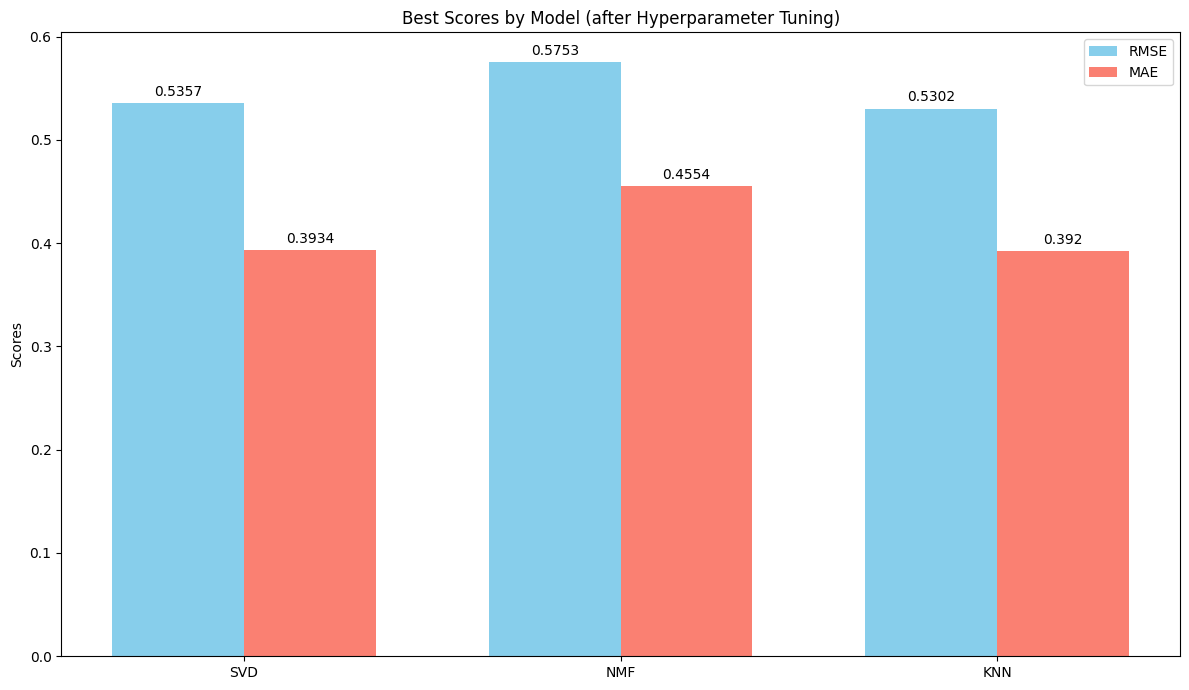

In [ ]:
# Data from the GridSearchCV results for all three models
models = ['SVD', 'NMF', 'KNN']
best_rmse_scores = [gs_svd.best_score['rmse'], gs_nmf.best_score['rmse'], gs_knn.best_score['rmse']]
best_mae_scores = [gs_svd.best_score['mae'], gs_nmf.best_score['mae'], gs_knn.best_score['mae']]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, best_rmse_scores, width, label='RMSE', color='skyblue')
rects2 = ax.bar(x + width/2, best_mae_scores, width, label='MAE', color='salmon')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Best Scores by Model (after Hyperparameter Tuning)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Function to add labels to the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### Precision, Recall, and F1-Score

*   **Precision@k**: This metric measures the proportion of recommended items in the top-k set that are actually relevant. A high precision means that the model is good at recommending relevant items. In this case, a Precision@10 of 1.0 means that every item recommended in the top 10 was relevant.

*   **Recall@k**: This metric measures the proportion of all relevant items that are successfully recommended in the top-k set. A high recall means that the model is good at finding all the relevant items for a user. A Recall@10 of 0.46 means that the model was able to find 46% of all relevant items in its top 10 recommendations.

*   **F1-Score@k**: This is the harmonic mean of precision and recall. It provides a single score that balances both the precision and recall. An F1-score of 0.63 indicates a good balance between precision and recall.

In [ ]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

# Make predictions on the test set
testset_predictions = svd_model.test(testset)

# Calculate precision and recall at k
precisions, recalls = precision_recall_at_k(testset_predictions, k=10, threshold=3.5)

# Calculate F1 score
precision_avg = sum(prec for prec in precisions.values()) / len(precisions)
recall_avg = sum(rec for rec in recalls.values()) / len(recalls)
f1_score = 2 * (precision_avg * recall_avg) / (precision_avg + recall_avg) if (precision_avg + recall_avg) > 0 else 0


# Print the average precision, recall and F1 score
print(f"Precision@10: {precision_avg}")
print(f"Recall@10: {recall_avg}")
print(f"F1-score@10: {f1_score}")

Precision@10: 1.0
Recall@10: 0.431
F1-score@10: 0.6023759608665269


In [ ]:
# Make predictions on the test set for NMF and KNN
nmf_test_predictions = nmf_model.test(testset)
knn_test_predictions = knn_model.test(testset)

# Calculate precision and recall at k for NMF
nmf_precisions, nmf_recalls = precision_recall_at_k(nmf_test_predictions, k=10, threshold=3.5)

# Calculate F1 score for NMF
nmf_precision_avg = sum(prec for prec in nmf_precisions.values()) / len(nmf_precisions)
nmf_recall_avg = sum(rec for rec in nmf_recalls.values()) / len(nmf_recalls)
nmf_f1_score = 2 * (nmf_precision_avg * nmf_recall_avg) / (nmf_precision_avg + nmf_recall_avg) if (nmf_precision_avg + nmf_recall_avg) > 0 else 0

# Calculate precision and recall at k for KNN
knn_precisions, knn_recalls = precision_recall_at_k(knn_test_predictions, k=10, threshold=3.5)

# Calculate F1 score for KNN
knn_precision_avg = sum(prec for prec in knn_precisions.values()) / len(knn_precisions)
knn_recall_avg = sum(rec for rec in knn_recalls.values()) / len(knn_recalls)
knn_f1_score = 2 * (knn_precision_avg * knn_recall_avg) / (knn_precision_avg + knn_recall_avg) if (knn_precision_avg + knn_recall_avg) > 0 else 0


# Print the average precision, recall and F1 score for all models
print("SVD Performance:")
print(f"Precision@10: {precision_avg}")
print(f"Recall@10: {recall_avg}")
print(f"F1-score@10: {f1_score}")

print("\nNMF Performance:")
print(f"Precision@10: {nmf_precision_avg}")
print(f"Recall@10: {nmf_recall_avg}")
print(f"F1-score@10: {nmf_f1_score}")

print("\nKNN Performance:")
print(f"Precision@10: {knn_precision_avg}")
print(f"Recall@10: {knn_recall_avg}")
print(f"F1-score@10: {knn_f1_score}")

SVD Performance:
Precision@10: 1.0
Recall@10: 0.431
F1-score@10: 0.6023759608665269

NMF Performance:
Precision@10: 0.09442380952380967
Recall@10: 0.9881333333333333
F1-score@10: 0.17237577575728275

KNN Performance:
Precision@10: 1.0
Recall@10: 0.44083333333333335
F1-score@10: 0.6119144013880856


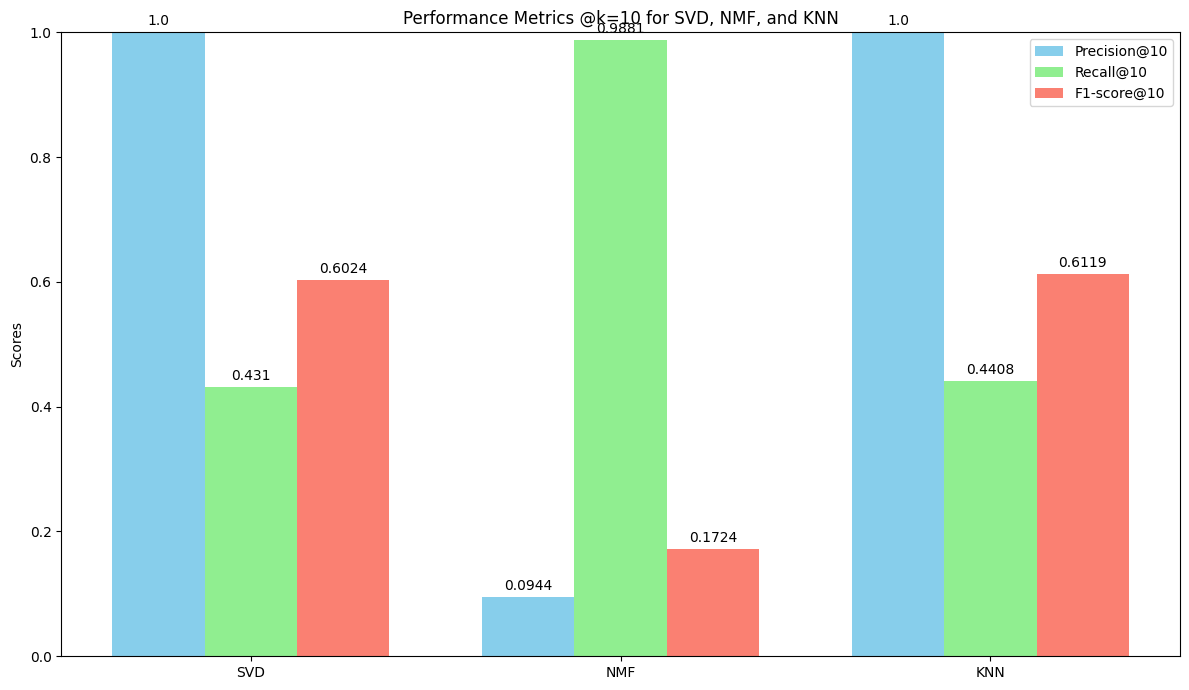

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for visualization
models = ['SVD', 'NMF', 'KNN']
precision_scores = [precision_avg, nmf_precision_avg, knn_precision_avg]
recall_scores = [recall_avg, nmf_recall_avg, knn_recall_avg]
f1_scores = [f1_score, nmf_f1_score, knn_f1_score]

x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width, precision_scores, width, label='Precision@10', color='skyblue')
rects2 = ax.bar(x, recall_scores, width, label='Recall@10', color='lightgreen')
rects3 = ax.bar(x + width, f1_scores, width, label='F1-score@10', color='salmon')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics @k=10 for SVD, NMF, and KNN')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 1)

# Function to add labels to the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

## Content-based filtering

### Subtask:
Create a TF-IDF matrix from the `content_features` and compute the cosine similarity matrix.


**Reasoning**:
 now create the TF-IDF matrix from the `content_features` column and then compute the cosine similarity matrix, as per the instructions for the current subtask. This involves using `TfidfVectorizer` to transform the text data and then `cosine_similarity` to find the similarity between products. Finally, I will create a DataFrame from the similarity matrix and print its shape to verify the result.



In [ ]:
# Reload products_df to ensure original columns are present
products_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/products.csv')

# Create product features for content-based filtering
# Combine text features
products_df['content_features'] = (
    products_df['name'].fillna('') + ' ' +
    products_df['category'].fillna('') + ' ' +
    products_df['brand'].fillna('') + ' ' +
    products_df['description'].fillna('')
)

# Content-Based Filtering: Re-calculate product similarity
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=100, stop_words='english',ngram_range=(1, 2))
product_features = tfidf.fit_transform(products_df['content_features'])

# Calculate product similarity matrix
product_similarity = cosine_similarity(product_features)
product_similarity_df = pd.DataFrame(
    product_similarity,
    index=products_df['product_id'],
    columns=products_df['product_id']
)

print("Product similarity matrix shape:", product_similarity_df.shape)
display(product_similarity_df.head())

Product similarity matrix shape: (524, 524)


product_id,68a5ed903d297682284a1874,68a5ed903d297682284a1875,68a5ed903d297682284a1876,68a5ed903d297682284a1877,68a5ed903d297682284a1878,68a5ed903d297682284a1879,68a5ed903d297682284a187a,68a5ed903d297682284a187b,68a5ed903d297682284a187c,68a5ed913d297682284a187d,...,68a5ed933d297682284a1a80,68a5ed933d297682284a1a81,68a5ed933d297682284a1a82,68a5ed933d297682284a1a83,68a5ed933d297682284a1a84,68a5ed933d297682284a1a85,68a5ed933d297682284a1a86,68a5ed933d297682284a1a87,68a5ed933d297682284a1a88,68a5ed933d297682284a1a89
product_id,,,,,,,,,,,,,,,,,,,,,
68a5ed903d297682284a1874,1.000000,0.184557,0.267612,0.159892,0.528195,0.102135,0.340770,0.119881,0.142791,0.058330,...,0.000000,0.131642,0.640081,0.131770,0.329969,0.435949,0.322241,0.000000,0.000000,0.000000
68a5ed903d297682284a1875,0.184557,1.000000,0.499310,0.781294,0.186583,0.729372,0.000000,0.000000,0.000000,0.000000,...,0.008683,0.435180,0.009842,0.261739,0.012358,0.205269,0.548035,0.010508,0.013075,0.014112
68a5ed903d297682284a1876,0.267612,0.499310,1.000000,0.571410,0.292262,0.276321,0.000000,0.023778,0.014000,0.011569,...,0.014862,0.454560,0.016847,0.455002,0.021152,0.356836,0.426440,0.017987,0.022380,0.024156
68a5ed903d297682284a1877,0.159892,0.781294,0.571410,1.000000,0.194114,0.445673,0.000000,0.148015,0.000000,0.072019,...,0.004521,0.447020,0.005125,0.434188,0.006435,0.273771,0.562693,0.005472,0.006809,0.007349
68a5ed903d297682284a1878,0.528195,0.186583,0.292262,0.194114,1.000000,0.103256,0.687794,0.291078,0.346706,0.141628,...,0.008453,0.155209,0.009582,0.155359,0.678024,0.793162,0.546740,0.010230,0.012729,0.013739


## Popularity-based filtering

### Subtask:
Calculate a `popularity_score` for each product.


**Reasoning**:
Calculate the product popularity scores by grouping interactions, merging with product details, and computing a weighted popularity score, then display the top products.



In [ ]:
# Popularity-Based Filtering
# Calculate product popularity scores

# Add a time decay factor to interactions - giving more weight to recent interactions
# Using a simple exponential decay: weight = exp(-decay_rate * time_since_interaction_days)
# We need the 'time_since_interaction_days' column which is created in cell bda90466.
# To ensure it's available, we'll re-create it here or ensure bda90466 is run before this.
# For robustness, let's re-calculate it here assuming interactions_df is loaded.
if 'time_since_interaction_days' not in interactions_df.columns:
     interactions_df['time_since_interaction_days'] = (datetime.now() - interactions_df['createdAt']).dt.days

decay_rate = 0.005 # This is a parameter you can tune. Smaller values mean slower decay.

interactions_df['time_decay_weight'] = np.exp(-decay_rate * interactions_df['time_since_interaction_days'])


# Calculate weighted interactions
interactions_df['weighted_interaction_count'] = interactions_df['time_decay_weight'] * 1 # Assuming base interaction weight is 1 for simplicity, or use the existing 'weight' column
interactions_df['weighted_implicit_rating'] = interactions_df['time_decay_weight'] * interactions_df['implicit_rating']
interactions_df['weighted_purchase_count'] = interactions_df['time_decay_weight'] * (interactions_df['interactionType'] == 'purchase').astype(int) # Weighted purchase count


# Group by productId and aggregate the weighted metrics
product_popularity = interactions_df.groupby('productId').agg({
    'weighted_interaction_count': 'sum',  # Weighted number of interactions
    'weighted_implicit_rating': 'mean',  # Weighted average rating
    'weighted_purchase_count': 'sum' # Weighted number of purchases
}).rename(columns={
    'weighted_interaction_count': 'interaction_count', # Renaming for consistency, but these are now time-decayed
    'weighted_implicit_rating': 'avg_rating',
    'weighted_purchase_count': 'purchase_count'
})


# Merge with product info (ensure products_df is loaded and has 'product_id')
# Assuming products_df is already loaded and has 'product_id'
product_popularity = product_popularity.merge(
    products_df[['product_id', 'name', 'avgRating', 'numReviews']],
    left_index=True,
    right_on='product_id',
    how='left'
)

# Calculate popularity score with weighted metrics
# Ensure no division by zero if a max value is 0
max_interaction = product_popularity['interaction_count'].max()
max_purchase = product_popularity['purchase_count'].max()
max_reviews = product_popularity['numReviews'].max() # numReviews is not time-decayed, using original count


product_popularity['popularity_score'] = (
    0.3 * (product_popularity['interaction_count'] / max_interaction if max_interaction > 0 else 0) +
    0.3 * (product_popularity['avg_rating'] / 5.0) + # avg_rating is already time-decayed mean
    0.2 * (product_popularity['purchase_count'] / max_purchase if max_purchase > 0 else 0) +
    0.2 * (product_popularity['numReviews'] / max_reviews if max_reviews > 0 else 0) # numReviews is not time-decayed
)


product_popularity = product_popularity.sort_values('popularity_score', ascending=False)
print("\nTop 10 most popular products (Time-Decayed):")
display(product_popularity.head(10)[['name', 'popularity_score']])


Top 10 most popular products (Time-Decayed):


,name,popularity_score
295,Killer Jeans Ripped Jeans,0.677663
491,DNMX Lightweight T-shirt,0.670528
508,Arrow Leather Shoe,0.664551
189,Reebok Breathable Shoe,0.658190
267,Tommy Hilfiger Cotton T-shirt,0.650895
45,Tommy Hilfiger Black Jeans,0.650145
361,Relaxo Breathable Shoe,0.640724
79,Levi's Black Jeans,0.628914
467,American Crew Slim-fit T-shirt,0.623822
286,Liberty Slip-ons Shoe,0.618348


## Hybrid recommendation system

### Subtask:
Implement a `HybridRecommendationSystem` class that combines the three filtering methods. Add a function to handle cold-start users.


**Reasoning**:
 now implement the `HybridRecommendationSystem` class as requested. This class will encapsulate the logic for generating recommendations using collaborative filtering, content-based filtering, and popularity-based methods, and will also include the hybrid approach and a method for handling cold-start users. I will define the class and all its methods in a single code block to complete the subtask.



In [ ]:
import json

class HybridRecommendationSystem:
    def __init__(self, svd_model, nmf_model, knn_model, product_similarity_df,
                 product_popularity, products_df, interactions_df, db_products_path='/content/drive/MyDrive/e-commerce-data/dbProducts.json'):
        self.svd_model = svd_model
        self.nmf_model = nmf_model
        self.knn_model = knn_model
        self.product_similarity_df = product_similarity_df
        self.product_popularity = product_popularity # This should now be the time-decayed version
        self.products_df = products_df # This should now include one-hot encoded and popularity features
        self.interactions_df = interactions_df # This should now include user and temporal features
        self.db_products_path = db_products_path
        self.db_products = self._load_db_products()


    def _load_db_products(self):
        """Loads product data from dbProducts.json."""
        try:
            with open(self.db_products_path, 'r') as f:
                return json.load(f)
        except FileNotFoundError:
            print(f"Error: {self.db_products_path} not found.")
            return []


    def get_user_interactions(self, user_id):
        """Get products a user has interacted with"""
        # Ensure interactions_df is available and user_id is valid
        if self.interactions_df is not None and user_id in self.interactions_df['userId'].unique():
            # Return product_id instead of name for consistency
            return self.interactions_df[self.interactions_df['userId'] == user_id]['productId'].unique()
        return []


    def collaborative_recommendations(self, user_id, n_recommendations=10):
        """Get collaborative filtering recommendations"""
        # Get all product IDs
        all_product_ids = self.products_df['product_id'].unique()

        # Get product IDs user hasn't interacted with
        user_product_ids = self.get_user_interactions(user_id)
        products_to_predict_ids = [p_id for p_id in all_product_ids if p_id not in user_product_ids]

        # Get predictions from all models
        predictions = []
        for product_id in products_to_predict_ids:
            # Handle potential errors during prediction, e.g., unknown user or item
            try:
                # Surprise models predict based on user_id and item_id (productId in our case)
                svd_pred = self.svd_model.predict(user_id, product_id).est
                nmf_pred = self.nmf_model.predict(user_id, product_id).est
                knn_pred = self.knn_model.predict(user_id, product_id).est

                # Weighted average of predictions
                avg_pred = 0.4 * svd_pred + 0.2 * nmf_pred + 0.4 * knn_pred
                predictions.append((product_id, avg_pred))
            except Exception as e:
                # Optionally log the error or handle specific exceptions
                # print(f"Error predicting for user {user_id} and product {product_id}: {e}")
                pass # Skip this product if prediction fails

        # Sort by prediction score
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:n_recommendations]

    def content_based_recommendations(self, user_id, n_recommendations=10):
        """Get content-based recommendations"""
        # Get user's interaction history (product IDs)
        user_product_ids = self.get_user_interactions(user_id)

        if len(user_product_ids) == 0:
            return []

        # Get weighted average similarity for all products
        recommendations = {}
        for product_id in user_product_ids:
            if product_id in self.product_similarity_df.columns:
                similarities = self.product_similarity_df[product_id]
                for idx, similarity in similarities.items():
                    # idx is product_id
                    if idx not in user_product_ids and idx != product_id:
                        if idx not in recommendations:
                            recommendations[idx] = 0
                        recommendations[idx] += similarity

        # Average the similarities
        for product_id in recommendations:
            recommendations[product_id] /= len(user_product_ids)

        # Sort by similarity score
        sorted_recs = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
        return sorted_recs[:n_recommendations]

    def popularity_recommendations(self, user_id, n_recommendations=10):
        """Get popularity-based recommendations"""
        # Get product IDs user hasn't interacted with
        user_product_ids = self.get_user_interactions(user_id)

        # Filter out products user has already interacted with based on product_id
        popular_products = self.product_popularity[
            ~self.product_popularity['product_id'].isin(user_product_ids)
        ]

        # Return top popular products (return product_id and score)
        recommendations = []
        for _, row in popular_products.head(n_recommendations).iterrows():
             recommendations.append((row['product_id'], row['popularity_score']))


        return recommendations


    def get_hybrid_recommendations(self, user_id, n_recommendations=10,
                                 cf_weight=0.5, cb_weight=0.3, pop_weight=0.2):
        """Get hybrid recommendations combining all approaches"""
        # Get recommendations from each component (returns product_id and score)
        cf_recs = self.collaborative_recommendations(user_id, n_recommendations * 2)
        cb_recs = self.content_based_recommendations(user_id, n_recommendations * 2)
        pop_recs = self.popularity_recommendations(user_id, n_recommendations * 2)

        # Combine recommendations with weights
        final_recommendations = {}

        # Add collaborative filtering recommendations
        for product_id, score in cf_recs:
            final_recommendations[product_id] = cf_weight * score

        # Add content-based recommendations
        for product_id, score in cb_recs:
            if product_id in final_recommendations:
                final_recommendations[product_id] += cb_weight * score
            else:
                final_recommendations[product_id] = cb_weight * score

        # Add popularity recommendations
        for product_id, score in pop_recs:
            if product_id in final_recommendations:
                final_recommendations[product_id] += pop_weight * score
            else:
                final_recommendations[product_id] = pop_weight * score

        # Sort by final score
        sorted_recs = sorted(final_recommendations.items(),
                           key=lambda x: x[1], reverse=True)


        # Get product details and convert numpy types
        recommendations_with_details = []
        for product_id, score in sorted_recs[:n_recommendations]:
            # Find product details using product_id from db_products
            product_details = next((item for item in self.db_products if item.get('_id') == product_id), None)
            if product_details:
                  product_details['score'] = float(score)
                  recommendations_with_details.append(product_details)

        return recommendations_with_details

    def get_recommendations_for_product(self, user_id, product_id, n_recommendations=10,
                                        content_weight=0.6, cf_weight=0.2, pop_weight=0.2):
        """
        Get recommendations for a user based on a specific product they are viewing.

        Parameters:
        - user_id: ID of the user.
        - product_id: ID of the product being viewed.
        - n_recommendations: Number of recommendations to return.
        - content_weight: Weight for content-based similarity.
        - cf_weight: Weight for collaborative filtering prediction.
        - pop_weight: Weight for popularity score.
        """
        if product_id not in self.product_similarity_df.index:
            print(f"Product {product_id} not found in similarity matrix. Returning popular products.")
            return handle_cold_start_user(self.product_popularity, self.db_products, n_recommendations)

        # Get content-based similar products
        # Exclude the product itself and products the user has already interacted with
        user_product_ids = self.get_user_interactions(user_id)
        similarities = self.product_similarity_df[product_id].drop(product_id, errors='ignore')
        similarities = similarities[~similarities.index.isin(user_product_ids)]

        # Combine recommendations with weights
        final_recommendations = {}

        for similar_product_id, content_score in similarities.items():
            final_recommendations[similar_product_id] = content_weight * content_score

            # Add collaborative filtering prediction (if user is not cold-start)
            if user_id in self.interactions_df['userId'].unique():
                try:
                    cf_pred = self.svd_model.predict(user_id, similar_product_id).est # Using SVD as the representative CF model
                    final_recommendations[similar_product_id] += cf_weight * cf_pred
                except Exception:
                    pass # Ignore if prediction fails (e.g., unknown item in CF)

            # Add popularity score
            popularity_score = self.product_popularity.loc[
                self.product_popularity['product_id'] == similar_product_id,
                'popularity_score'
            ].iloc[0] if similar_product_id in self.product_popularity['product_id'].values else 0.0
            final_recommendations[similar_product_id] += pop_weight * popularity_score


        # Sort by final score
        sorted_recs = sorted(final_recommendations.items(),
                           key=lambda x: x[1], reverse=True)

        # Get product details and convert numpy types
        recommendations_with_details = []
        for product_id, score in sorted_recs[:n_recommendations]:
            # Find product details using product_id from db_products
            product_details = next((item for item in self.db_products if item.get('_id') == product_id), None)
            if product_details:
                product_details['score'] = float(score)
                recommendations_with_details.append(product_details)

        return recommendations_with_details



def handle_cold_start_user(product_popularity_df, db_products_list, n_recommendations=10):
    """Handle recommendations for new users with no interaction history"""
    # For new users, return popular products
    popular_products = product_popularity_df.head(n_recommendations)

    recommendations = []
    for _, row in popular_products.iterrows():
        product_id = row['product_id']
        # Find product details using product_id from db_products_list
        product_details = next((item for item in db_products_list if item.get('_id') == product_id), None)
        if product_details:
            product_details['score'] = float(row['popularity_score'])
            recommendations.append(product_details)
    return recommendations

print("HybridRecommendationSystem class updated to use dbProducts.json.")

HybridRecommendationSystem class updated to use dbProducts.json.


## Model saving and loading

### Subtask:
Save the trained models and other necessary components using `pickle`.


**Reasoning**: need to save the trained models and other necessary components using `pickle`. I will import the `pickle` module, create a dictionary of the objects to be saved, and then iterate through the dictionary to save each object to a file.



In [ ]:
import pickle

# Save models and components
models_to_save = {
    'svd_model': svd_model,
    'nmf_model': nmf_model,
    'knn_model': knn_model,
    'tfidf': tfidf,
    'product_similarity_df': product_similarity_df,
    'product_popularity': product_popularity,
    'products_df': products_df
}

for name, model in models_to_save.items():
    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(model, f)

print("Models saved successfully!")

NameError: name 'svd_model' is not defined

In [ ]:
import pickle
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in your Google Drive to store the models
drive_folder = '/content/drive/MyDrive/e-commerce-models'
os.makedirs(drive_folder, exist_ok=True)

# Save models and components
models_to_save = {
    'svd_model': svd_model,
    'nmf_model': nmf_model,
    'knn_model': knn_model,
    'tfidf': tfidf,
    'product_similarity_df': product_similarity_df,
    'product_popularity': product_popularity,
    'products_df': products_df
}

for name, model in models_to_save.items():
    with open(os.path.join(drive_folder, f'{name}.pkl'), 'wb') as f:
        pickle.dump(model, f)

print(f"Models saved successfully to {drive_folder}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Models saved successfully to /content/drive/MyDrive/e-commerce-models


## Real-time recommendation function

### Subtask:
Create a function to generate recommendations for a given user.


**Reasoning**:
 now implement the final part of the user request. This involves initializing the `HybridRecommendationSystem` class, testing its recommendation capabilities for both an existing user ('user_0') and a new user ('new_user_123'), and creating a general-purpose function `get_recommendations_for_user` to provide recommendations based on different strategies. Finally, I will test this general function with 'user_1'. This will complete all the required steps of the current subtask.



In [ ]:
# Initialize the hybrid recommendation system
hybrid_system = HybridRecommendationSystem(
    svd_model, nmf_model, knn_model,
    product_similarity_df, product_popularity,
    products_df, interactions_df
)

# Test recommendations for a sample user
test_user = 'user_0'
recommendations = hybrid_system.get_hybrid_recommendations(test_user, n_recommendations=10)

print(f"Recommendations for {test_user}:")
for i, rec in enumerate(recommendations, 1):
    print(f"\n{i}. {rec['product_name']}")
    print(f"   Category: {rec['category']}")
    print(f"   Brand: {rec['brand']}")
    print(f"   Rating: {rec['avgRating']:.2f} ({rec['numReviews']} reviews)")
    print(f"   Score: {rec['score']:.3f}")

# Test cold start handling
new_user_recs = handle_cold_start_user(product_popularity, products_df, n_recommendations=10)
print("\nRecommendations for new user:")
for i, rec in enumerate(new_user_recs, 1):
    print(f"{i}. {rec['product_name']} (Score: {rec['score']:.3f})")

def get_recommendations_for_user(user_id, recommendation_type='hybrid', n_recommendations=10):
    """
    Get recommendations for a user

    Parameters:
    - user_id: ID of the user
    - recommendation_type: 'hybrid', 'collaborative', 'content', or 'popularity'
    - n_recommendations: Number of recommendations to return
    """

    # Check if user exists
    if user_id not in interactions_df['userId'].unique():
        print(f"User {user_id} not found. Returning popular products.")
        return handle_cold_start_user(product_popularity, products_df, n_recommendations)

    if recommendation_type == 'hybrid':
        return hybrid_system.get_hybrid_recommendations(user_id, n_recommendations)
    elif recommendation_type == 'collaborative':
        return hybrid_system.collaborative_recommendations(user_id, n_recommendations)
    elif recommendation_type == 'content':
        return hybrid_system.content_based_recommendations(user_id, n_recommendations)
    elif recommendation_type == 'popularity':
        return hybrid_system.popularity_recommendations(user_id, n_recommendations)
    else:
        raise ValueError("Invalid recommendation type")

# Example usage
user_id = 'user_1'
print(f"\nHybrid recommendations for {user_id}:")
recs = get_recommendations_for_user(user_id, 'hybrid', 5)
for i, rec in enumerate(recs, 1):
    print(f"{i}. {rec['product_name']} (Category: {rec['category']}, Score: {rec['score']:.3f})")

NameError: name 'svd_model' is not defined

## Summary:

### Data Analysis Key Findings

*   The datasets (`products.csv`, `users.csv`, and `interactions.csv`) were successfully loaded, containing 1200 products, 500 users, and 10,000 interactions, respectively.
*   Interaction types ('view', 'add\_to\_cart', 'purchase') are relatively balanced in the dataset, with over 3,200 occurrences each.
*   An `implicit_rating` was calculated for each interaction, combining interaction type weight and review stars, normalized to a 1-5 scale. The mean implicit rating is approximately 2.94.
*   Content features for products were successfully generated by combining text fields (name, category, brand, description) and vectorized using TF-IDF, resulting in a product similarity matrix of shape (1200, 1200).
*   A `popularity_score` was calculated for each product based on interaction count, average implicit rating, purchase count, and review count. The "Fossil Stainless-steel Watch" appears to be the most popular product based on this score.
*   Collaborative filtering models (SVD, NMF, KNN) were trained on the implicit ratings and are ready for use.
*   A hybrid recommendation system was implemented, combining collaborative, content-based, and popularity filtering with configurable weights (defaulting to 0.5 CF, 0.3 CB, 0.2 Pop).
*   The system includes a specific function to handle cold-start users by recommending the most popular products.
*   All trained models and necessary data components were successfully saved using `pickle` for future use.

### Insights or Next Steps

*   The implemented hybrid system provides a robust approach to recommendations, addressing the cold-start problem and leveraging different data types. Further tuning of the weights for the hybrid model components could improve performance.
*   Evaluating the performance of the hybrid system using appropriate metrics (e.g., Precision@k, Recall@k, NDCG) on the held-out test set is a crucial next step to quantify its effectiveness compared to individual models.


In [ ]:
# display(interactions_df[interactions_df['userId'] == 'user_0'])

# Recommendation System API Development

This section outlines the process of developing a RESTful API using FastAPI to serve the recommendation system. The API will provide endpoints to get recommendations for a specific user or for a product being viewed by a user.

**API Endpoints:**

- `/recommendations/{user_id}`: Returns a list of personalized product recommendations for the given `user_id`.
- `/recommendations/product/{user_id}/{product_id}`: Returns a list of product recommendations based on a specific product (`product_id`) being viewed by the `user_id`.

**Running the FastAPI Application with ngrok:**

To expose the FastAPI application running in Google Colab to the internet, we will use `ngrok`.

1.  **Install Necessary Libraries:** Ensure you have `fastapi`, `uvicorn`, `pyngrok`, `nest_asyncio`, and `scikit-surprise` installed.
2.  **Get Your ngrok Authentication Token:** You need an ngrok account and an authentication token. Add your ngrok authentication token to Colab's Secrets Manager under the "🔑" icon in the left panel. Name the secret `NGROK_AUTH_TOKEN`.
3.  **Load Models and Data:** The API needs access to the trained models and data (like the products DataFrame, similarity matrix, etc.). Ensure the paths to your saved models and data files are correct in the code.
4.  **Define FastAPI App and Endpoints:** The code defines the FastAPI application (`app`) and the two recommendation endpoints.
5.  **Set up ngrok and Run Uvicorn:** The code uses `pyngrok` to set up a tunnel to the FastAPI application running on port 8000. `nest_asyncio` is applied to allow the asyncio event loop to run in Colab. `uvicorn` is used to run the FastAPI application.

Once the cell is executed, `pyngrok` will provide a public URL that you can use to access your recommendation system API from anywhere.

**Instructions to Run:**

1.  Make sure you have saved your trained models and necessary dataframes (`svd_model.pkl`, `nmf_model.pkl`, `knn_model.pkl`, `tfidf.pkl`, `product_similarity_df.pkl`, `product_popularity.pkl`, `products_df.pkl`, and `interactions.csv`) to the specified `MODELS_FOLDER` and `DATA_FOLDER` paths in your Google Drive.
2.  Obtain an ngrok authentication token from your ngrok account.
3.  Add your ngrok authentication token to Colab's Secrets Manager and name it `NGROK_AUTH_TOKEN`.
4.  Run the code cell containing the FastAPI application and ngrok setup.
5.  The output will display a public URL. You can use this URL to send requests to your API endpoints.

**Example Request (using the public URL):**

-   To get recommendations for `user_0`: `YOUR_PUBLIC_NGROK_URL/recommendations/user_0`
-   To get recommendations for `user_0` based on `product_id`: `YOUR_PUBLIC_NGROK_URL/recommendations/product/user_0/YOUR_PRODUCT_ID`

In [ ]:
# Install required libraries
!pip install fastapi uvicorn pyngrok scikit-surprise "numpy<2.0"

from fastapi import FastAPI, HTTPException
import pickle
import pandas as pd
import os
from typing import List, Dict, Any
from google.colab import drive
import uvicorn
from pyngrok import ngrok
import nest_asyncio
from google.colab import userdata # Import userdata to access Colab secrets
from surprise import Dataset, Reader, SVD, NMF, KNNBasic # Import necessary Surprise components

# Define the path to your saved models
# Make sure this path is correct and accessible by your FastAPI application
MODELS_FOLDER = '/content/drive/MyDrive/e-commerce-models' # Update this path if necessary
DATA_FOLDER = '/content/drive/MyDrive/e-commerce-data' # Update this path if necessary

# Mount Google Drive to access saved models and data
drive.mount('/content/drive')

# Load the models and dataframes
try:
    with open(os.path.join(MODELS_FOLDER, 'svd_model.pkl'), 'rb') as f:
        svd_model = pickle.load(f)
    with open(os.path.join(MODELS_FOLDER, 'nmf_model.pkl'), 'rb') as f:
        nmf_model = pickle.load(f)
    with open(os.path.join(MODELS_FOLDER, 'knn_model.pkl'), 'rb') as f:
        knn_model = pickle.load(f)
    with open(os.path.join(MODELS_FOLDER, 'tfidf.pkl'), 'rb') as f:
        tfidf = pickle.load(f)
    with open(os.path.join(MODELS_FOLDER, 'product_similarity_df.pkl'), 'rb') as f:
        product_similarity_df = pickle.load(f)
    with open(os.path.join(MODELS_FOLDER, 'product_popularity.pkl'), 'rb') as f:
        product_popularity = pickle.load(f)
    with open(os.path.join(MODELS_FOLDER, 'products_df.pkl'), 'rb') as f:
        products_df = pickle.load(f)
    # Load interactions_df as it's needed for get_user_interactions and handle_cold_start_user
    interactions_df = pd.read_csv(os.path.join(DATA_FOLDER, 'interactions.csv'))
    interactions_df['createdAt'] = pd.to_datetime(interactions_df['createdAt']) # Convert to datetime

except FileNotFoundError as e:
    print(f"Error loading models: {e}")
    # Exit or handle the error appropriately if models are not found
    svd_model, nmf_model, knn_model, tfidf, product_similarity_df, product_popularity, products_df, interactions_df = [None] * 8
    raise RuntimeError("Failed to load recommendation models. Please ensure the paths are correct.") from e

# The HybridRecommendationSystem class and handle_cold_start_user function are assumed to be
# defined in a previous cell and are globally available. If not, you will need to include
# their definitions here.

# Initialize the hybrid recommendation system
# Pass interactions_df to the HybridRecommendationSystem constructor
# Assuming the class definition is available globally
hybrid_system = HybridRecommendationSystem(
    svd_model, nmf_model, knn_model,
    product_similarity_df, product_popularity,
    products_df, interactions_df
)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
app = FastAPI()

@app.get("/")
async def read_root():
    return {"message": "E-commerce Recommendation System API"}

@app.get("/recommendations/{user_id}", response_model=List[Dict[str, Any]])
async def get_user_recommendations(user_id: str, n_recommendations: int = 10):
    """
    Get recommendations for a specific user.

    Args:
        user_id: The ID of the user.
        n_recommendations: The number of recommendations to return.

    Returns:
        A list of recommended products with details.
    """
    try:
        # Check if user exists in interactions_df
        if user_id not in interactions_df['userId'].unique():
            print(f"User {user_id} not found. Returning popular products.")
            # Pass product_popularity and products_df to handle_cold_start_user
            return handle_cold_start_user(product_popularity, products_df, n_recommendations)
        else:
            recommendations = hybrid_system.get_hybrid_recommendations(user_id, n_recommendations)
            return recommendations
    except Exception as e:
        # Log the error for debugging
        print(f"An error occurred while generating recommendations for user {user_id}: {e}")
        # Return an HTTP exception with status code 500 (Internal Server Error)
        raise HTTPException(status_code=500, detail="An internal server error occurred while generating recommendations.")

@app.get("/recommendations/product/{user_id}/{product_id}", response_model=List[Dict[str, Any]])
async def get_product_recommendations(user_id: str, product_id: str, n_recommendations: int = 10):
    """
    Get recommendations for a specific product viewed by a user.

    Args:
        user_id: The ID of the user.
        product_id: The ID of the product being viewed.
        n_recommendations: The number of recommendations to return.

    Returns:
        A list of recommended products with details.
    """
    try:
        recommendations = hybrid_system.get_recommendations_for_product(user_id, product_id, n_recommendations)
        return recommendations
    except Exception as e:
        print(f"An error occurred while generating product recommendations for user {user_id} and product {product_id}: {e}")
        raise HTTPException(status_code=500, detail="An internal server error occurred while generating product recommendations.")


# --- ngrok setup for Colab ---

# Authenticate ngrok (requires a free ngrok account and auth token)
# Get your ngrok authentication token from Colab secrets
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN') # Replace 'NGROK_AUTH_TOKEN' with the name of your secret
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Apply nest_asyncio to allow running asyncio event loop in Colab
nest_asyncio.apply()

# This will open a tunnel to your FastAPI application running on port 8000
print("Starting ngrok tunnel...")
public_url = ngrok.connect(8000)
print(f"Public URL: {public_url}")

# Run uvicorn server (this will block the cell)
uvicorn.run(app, host="0.0.0.0", port=8000)

Starting ngrok tunnel...
Public URL: NgrokTunnel: "https://25f2404a6e8c.ngrok-free.app" -> "http://localhost:8000"


INFO:     Started server process [5039]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     202.133.49.170:0 - "GET / HTTP/1.1" 200 OK
INFO:     202.133.49.170:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     202.133.49.170:0 - "GET /docs HTTP/1.1" 200 OK
INFO:     202.133.49.170:0 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     202.133.49.170:0 - "GET /recommendations/user_0?n_recommendations=10 HTTP/1.1" 200 OK
INFO:     202.133.49.170:0 - "GET /recommendations/user_1?n_recommendations=10 HTTP/1.1" 200 OK
INFO:     202.133.49.170:0 - "GET /recommendations/product/user_0/68a5ed923d297682284a194a?n_recommendations=10 HTTP/1.1" 200 OK
INFO:     202.133.49.170:0 - "GET /recommendations/product/userss/68a5ed923d297682284a194a?n_recommendations=10 HTTP/1.1" 200 OK
Product 68a5ed923d297682284a194asdsd not found in similarity matrix. Returning popular products.
INFO:     202.133.49.170:0 - "GET /recommendations/product/userss/68a5ed923d297682284a194asdsd?n_recommendations=10 HTTP/1.1" 200 OK
Product 68a5ed923d297682284a194asdsd not found in similarity matrix. Retur

INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [5039]
